# **Projet 7 : Réalisez une analyse de sentiments grâce au Deep Learning**

par Vincent Dujardin

## **Contexte**

Dans un contexte où la réputation en ligne joue un rôle crucial pour les entreprises, Air Paradis, une compagnie aérienne, cherche à anticiper et mieux gérer les bad buzz sur les réseaux sociaux. Pour cela, elle a mandaté Marketing Intelligence Consulting (MIC), un cabinet spécialisé en intelligence artificielle appliquée au marketing digital, afin de développer un prototype d’un modèle de prédiction de sentiment des tweets. Ce modèle devra être accessible via une API cloud et intégré à une interface utilisateur permettant d’analyser des tweets en temps réel.

Par ailleurs, MIC souhaite tirer parti de cette opportunité pour expérimenter plusieurs approches de modélisation et intégrer des bonnes pratiques MLOps afin d’industrialiser et fiabiliser le processus de développement et de déploiement des modèles d’IA.

## **Objectifs**

L'objectif principal est de développer et déployer un prototype fonctionnel d’un modèle de prédiction du sentiment des tweets pour Air Paradis, basé sur des données open-source. Pour répondre à cette mission, plusieurs sous-objectifs ont été définis :

1. Expérimentation de plusieurs modèles de NLP
    -  Un modèle simple basé sur une approche classique (ex. : régression logistique).
    -  Un modèle avancé utilisant des réseaux de neurones profonds, comparant plusieurs techniques d’embedding (Word2Vec, GloVe, BERT) pour optimiser les performances.

2. Mise en place des bonnes pratiques MLOps
    -  Suivi et gestion des expériences avec MLFlow (tracking des performances, gestion des versions des modèles).
    -  Déploiement du modèle sous forme d’API sur une solution Cloud gratuite (ex. : Azure Web App, Heroku, PythonAnywhere).
    -  Intégration d’un pipeline CI/CD pour automatiser le déploiement du modèle via GitHub Actions.
    -  Monitoring du modèle en production via Azure Application Insights, avec des alertes en cas de performances dégradées.

3. Communication et documentation
    -  Présentation des méthodologies et résultats dans un support clair destiné à une audience non technique.
    -  Rédaction d’un article de blog mettant en avant la démarche de modélisation et les apports du MLOps pour MIC.

## **1. Préparation**

In [1]:
# Importation des bibliothèques essentielles

# Gestion des fichiers et des opérations système
import os
from pathlib import Path
import json

# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # Permet de visualiser les valeurs manquantes dans le dataset
from wordcloud import WordCloud  # Génération de nuages de mots pour visualiser les termes les plus fréquents

# Affichage stylisé et outils interactifs pour Jupyter Notebook
from IPython.display import Markdown
import ace_tools_open as tools  # Outils pour afficher des DataFrames et autres visualisations interactives

# Expressions régulières (pour nettoyage et prétraitement du texte)
import re

# Traitement du langage naturel (NLP) avec NLTK
import nltk
from nltk.corpus import stopwords  # Stopwords pour suppression des mots courants
from nltk.tokenize import word_tokenize  # Tokenization des phrases
from nltk.stem import WordNetLemmatizer  # Lemmatisation des mots (réduction à la racine)

# Téléchargement des ressources NLTK nécessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Modélisation de texte avec Word Embeddings (Gensim)
from gensim.models import Word2Vec  # Word2Vec pour l'apprentissage de représentations vectorielles de mots
from gensim.models import FastText # FastText

# Scikit-learn : Prétraitement et modélisation
from sklearn.model_selection import train_test_split  # Séparation du dataset en train et test
from sklearn.feature_extraction.text import TfidfVectorizer  # Vectorisation des textes avec TF-IDF
from sklearn.feature_extraction.text import CountVectorizer  # Vectorisation des textes avec BoW (Bag of Words)
from sklearn.preprocessing import LabelEncoder  # Encodage des labels catégoriels

# Modèles d'apprentissage machine classiques
from sklearn.linear_model import LogisticRegression  # Régression logistique pour la classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Métriques d'évaluation
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score # Métriques d'évaluation (suite)

# TensorFlow / Keras : Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer  # Tokenization des textes pour le deep learning
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Padding des séquences textuelles
from tensorflow.keras.models import Sequential  # Modèle séquentiel pour le Deep Learning
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout  # Couches pour les réseaux de neurones récurrents (LSTM) et fully connected
from tensorflow.keras.callbacks import EarlyStopping  # Early stopping pour éviter l'overfitting

# MLflow : Suivi des expérimentations et gestion des modèles
import mlflow
import mlflow.sklearn
import mlflow.keras
import mlflow.tensorflow  # Tracking des modèles TensorFlow avec MLflow
from mlflow.models import infer_signature

from transformers import DistilBertTokenizer, TFDistilBertModel
import warnings
warnings.simplefilter("ignore")
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moussetik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Moussetik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Moussetik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Vérification si TensorFlow a été compilé avec CUDA (support GPU)
if tf.test.is_built_with_cuda():
    print("TensorFlow a été compilé avec CUDA: OUI")  # Indique si TensorFlow a accès à CUDA
else:
    print("TensorFlow a été compilé avec CUDA: NON")   # Indique que l'exécution se fera uniquement sur CPU

# Affichage des GPUs disponibles pour TensorFlow
print("GPUs disponible:", tf.config.list_physical_devices('GPU'))  # Liste les GPU accessibles


TensorFlow a été compilé avec CUDA: OUI
GPUs disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Récupération de la liste des GPUs physiques disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Activer la croissance dynamique de la mémoire GPU (évite l'allocation complète)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Forcer l'utilisation du premier GPU détecté
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Vérification après activation
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ TensorFlow utilise maintenant le GPU : {logical_gpus[0].name}")
        print(f"{len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s) disponibles.")

    except RuntimeError as e:
        print("⚠️ Erreur lors de la configuration du GPU :", e)

else:
    print("⚠️ Aucun GPU détecté, TensorFlow utilisera le CPU.")


✅ TensorFlow utilise maintenant le GPU : /device:GPU:0
1 Physical GPU(s), 1 Logical GPU(s) disponibles.


In [4]:
import pandas as pd

# --- Chargement des données ---

# Définition du chemin vers le fichier CSV contenant les tweets labellisés
file_path = "../data/sentiment140/training.1600000.processed.noemoticon.csv"

# Lecture du fichier CSV sans noms de colonnes (header=None), encodé en 'latin-1' (évite les erreurs d'encodage)
data = pd.read_csv(file_path, encoding='latin-1', header=None)

# Affichage des 5 premières lignes du dataset pour vérification
data.head()


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## **2. Analyse exploratoire des données**

### **A. Analyse univariée**

In [5]:
# --- Affichage des dimensions du dataset ---

# Récupération du nombre de lignes (individus) et de colonnes (variables)
nb_individus = data.shape[0]
nb_variables = data.shape[1]

# Affichage des dimensions du dataset sous format Markdown pour une meilleure présentation
display(Markdown(f"Le jeu de données contient **{nb_individus} individus** (lignes) et **{nb_variables} variables** (colonnes)."))


Le jeu de données contient **1600000 individus** (lignes) et **6 variables** (colonnes).

In [6]:
# --- Analyse des types de variables dans le DataFrame ---

# Comptage du nombre de colonnes pour chaque type de données
type_counts = data.dtypes.value_counts()

# Formatage des résultats pour un affichage structuré en Markdown
nb_types = ', \n- '.join(f'**{count}** variables **{dtype}**' for dtype, count in type_counts.items())

# Affichage des informations sous format Markdown pour une meilleure lisibilité
display(Markdown(f"Notre DataFrame est composé de :\n- {nb_types}."))


Notre DataFrame est composé de :
- **4** variables **object**, 
- **2** variables **int64**.

**<u>Commentaire :</u>**

Dans le [Kaggle d'origine](https://www.kaggle.com/datasets/kazanova/sentiment140) nous avons le noms des colonnes, nous les ajoutons à notre dataset.

In [7]:
# --- Renommage des colonnes du DataFrame ---

# Attribution de noms explicites aux colonnes du dataset
data.columns = ["target", "ids", "date", "flag", "user", "text"]

# Vérification du changement en affichant les 5 premières lignes
data.head()


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
# --- Vérification de la distribution des classes cibles ---

# Comptage du nombre d'occurrences pour chaque valeur de la colonne "target" (sentiment)
target_counts = data['target'].value_counts()

# Affichage des résultats
print(target_counts)


target
0    800000
4    800000
Name: count, dtype: int64


**<u>Commentaire :</u>**

Dans le [Kaggle d'origine](https://www.kaggle.com/datasets/kazanova/sentiment140) nous avons l'information suivante :

-  Les tweets ont été annotés (0 = négatif, 4 = positif).

Vérifions si les données sont équilibrées.

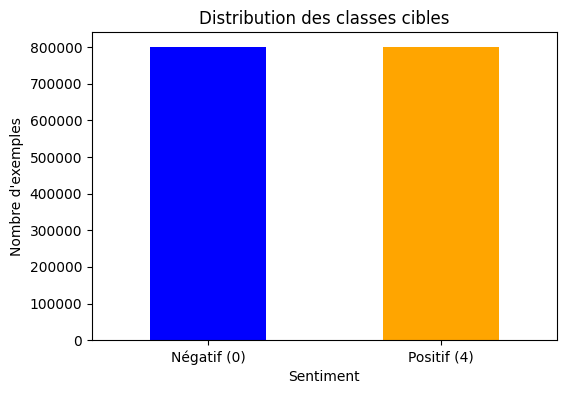

In [9]:
# --- Visualisation de la distribution des classes cibles ---

# Création d'une figure avec une taille définie pour une meilleure lisibilité
plt.figure(figsize=(6, 4))

# Création du graphique en barres représentant la distribution des classes cibles
target_counts.plot(kind='bar', color=['blue', 'orange'])

# Ajout des labels et du titre pour améliorer la compréhension du graphique
plt.xlabel("Sentiment")  # Axe des abscisses
plt.ylabel("Nombre d'exemples")  # Axe des ordonnées
plt.title("Distribution des classes cibles")  # Titre du graphique

# Personnalisation des ticks de l'axe X (étiquettes des classes)
plt.xticks(ticks=[0, 1], labels=["Négatif (0)", "Positif (4)"], rotation=0)

# Affichage du graphique
plt.show()


**<u>Commentaire :</u>**

Le jeu est équilibré, vérifions les valeurs manquantes.

In [10]:
# --- Vérification des valeurs manquantes dans le dataset ---

# Affichage du nombre de valeurs manquantes par variable
data.isnull().sum()


target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

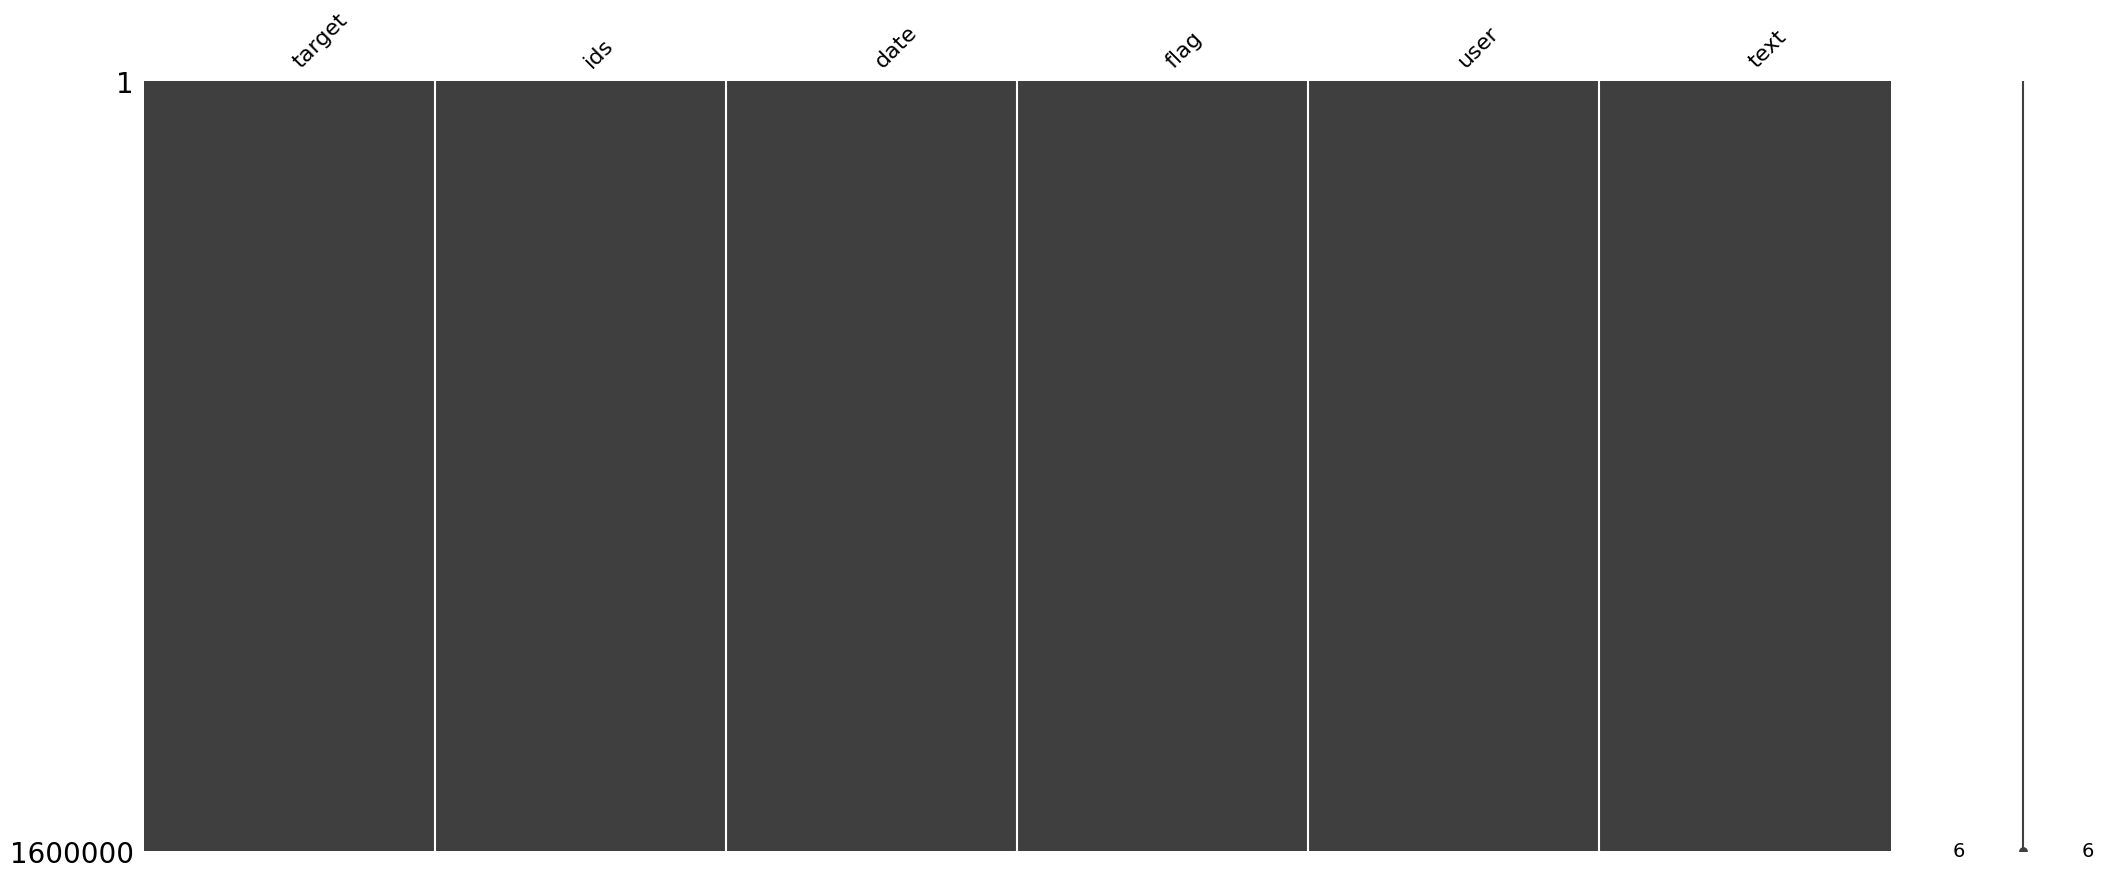

In [11]:
# --- Visualisation des valeurs manquantes dans le dataset ---

# Affichage d'une matrice montrant la présence de valeurs manquantes
msno.matrix(data)

# Affichage du graphique
plt.show()


**<u>Commentaire :</u>**

Il n'y a pas de valeurs manquantes. Analysons les tweets.

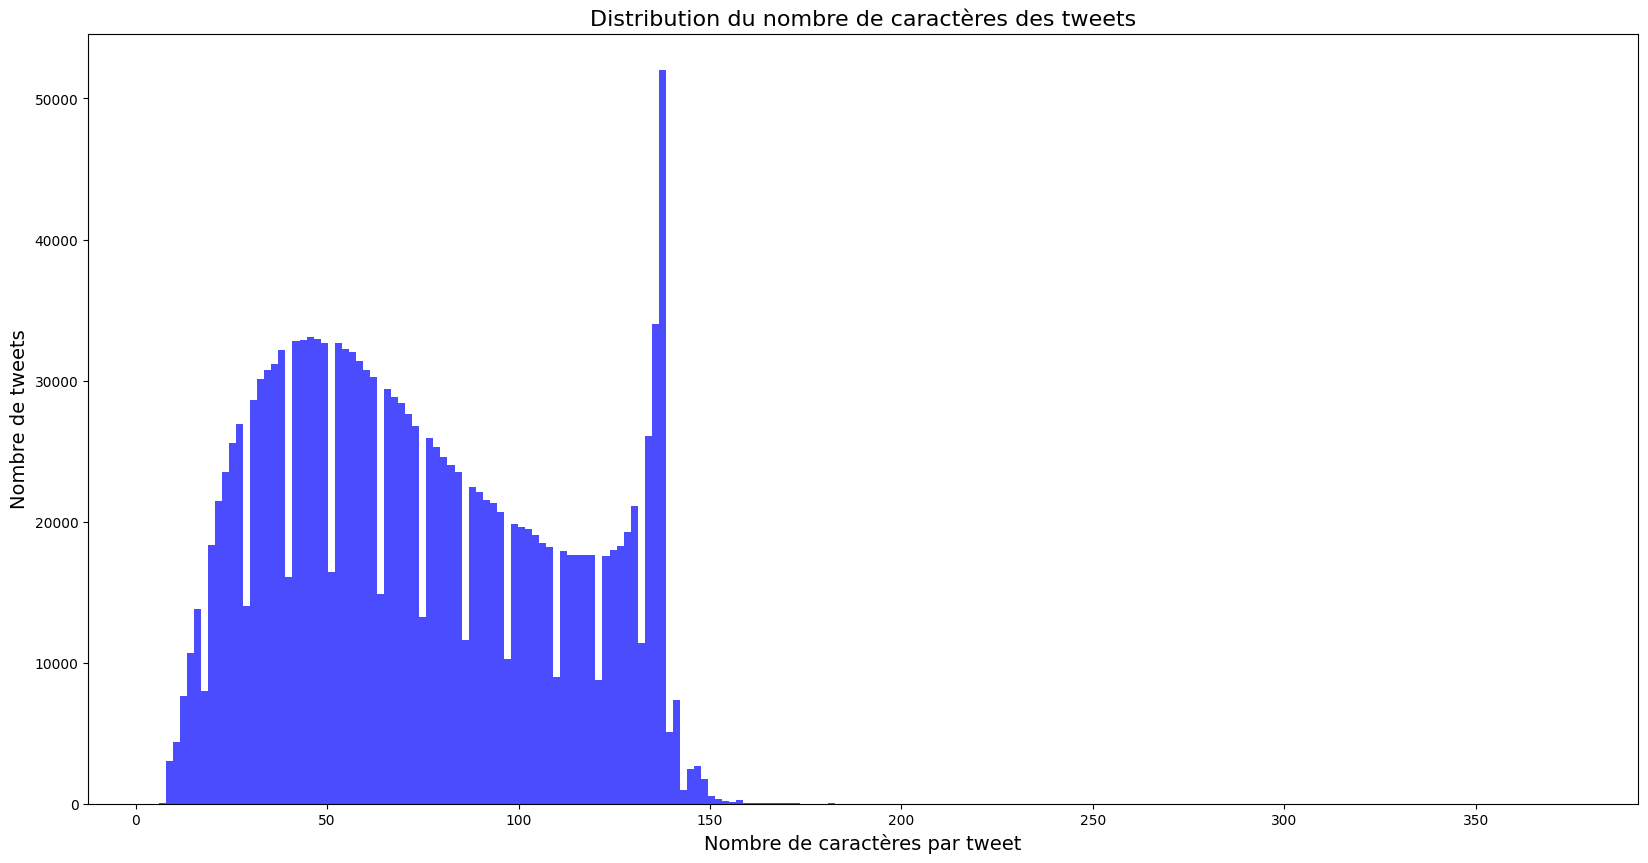

In [12]:
# --- Analyse de la longueur des tweets ---

# Création d'une figure avec une taille ajustée pour une meilleure lisibilité
plt.figure(figsize=(20, 10))

# Création de l'histogramme de la distribution de la longueur des tweets
plt.hist(
    data["text"].apply(lambda x: len(x)).values,  # Calcul de la longueur de chaque tweet
    bins=200,  # Nombre de bins pour affiner la distribution
    color="blue",  # Couleur des barres pour une meilleure visibilité
    alpha=0.7  # Transparence pour améliorer la lisibilité
)

# Ajout des titres et labels
plt.title("Distribution du nombre de caractères des tweets", fontsize=16)
plt.xlabel("Nombre de caractères par tweet", fontsize=14)
plt.ylabel("Nombre de tweets", fontsize=14)

# Affichage du graphique
plt.show()


In [13]:
# --- Suite de l'analyse statistique de la longueur des tweets ---

# Calcul de la longueur de chaque tweet
tweet_lengths = data["text"].apply(len)

# Affichage des statistiques sur la longueur des tweets
print(f"📊 Statistiques sur la longueur des tweets :")
print(f"▶ Longueur moyenne  : {tweet_lengths.mean():.2f} caractères")
print(f"▶ Longueur médiane  : {tweet_lengths.median():.2f} caractères")
print(f"▶ Longueur max      : {tweet_lengths.max()} caractères")
print(f"▶ Longueur min      : {tweet_lengths.min()} caractères")


📊 Statistiques sur la longueur des tweets :
▶ Longueur moyenne  : 74.09 caractères
▶ Longueur médiane  : 69.00 caractères
▶ Longueur max      : 374 caractères
▶ Longueur min      : 6 caractères


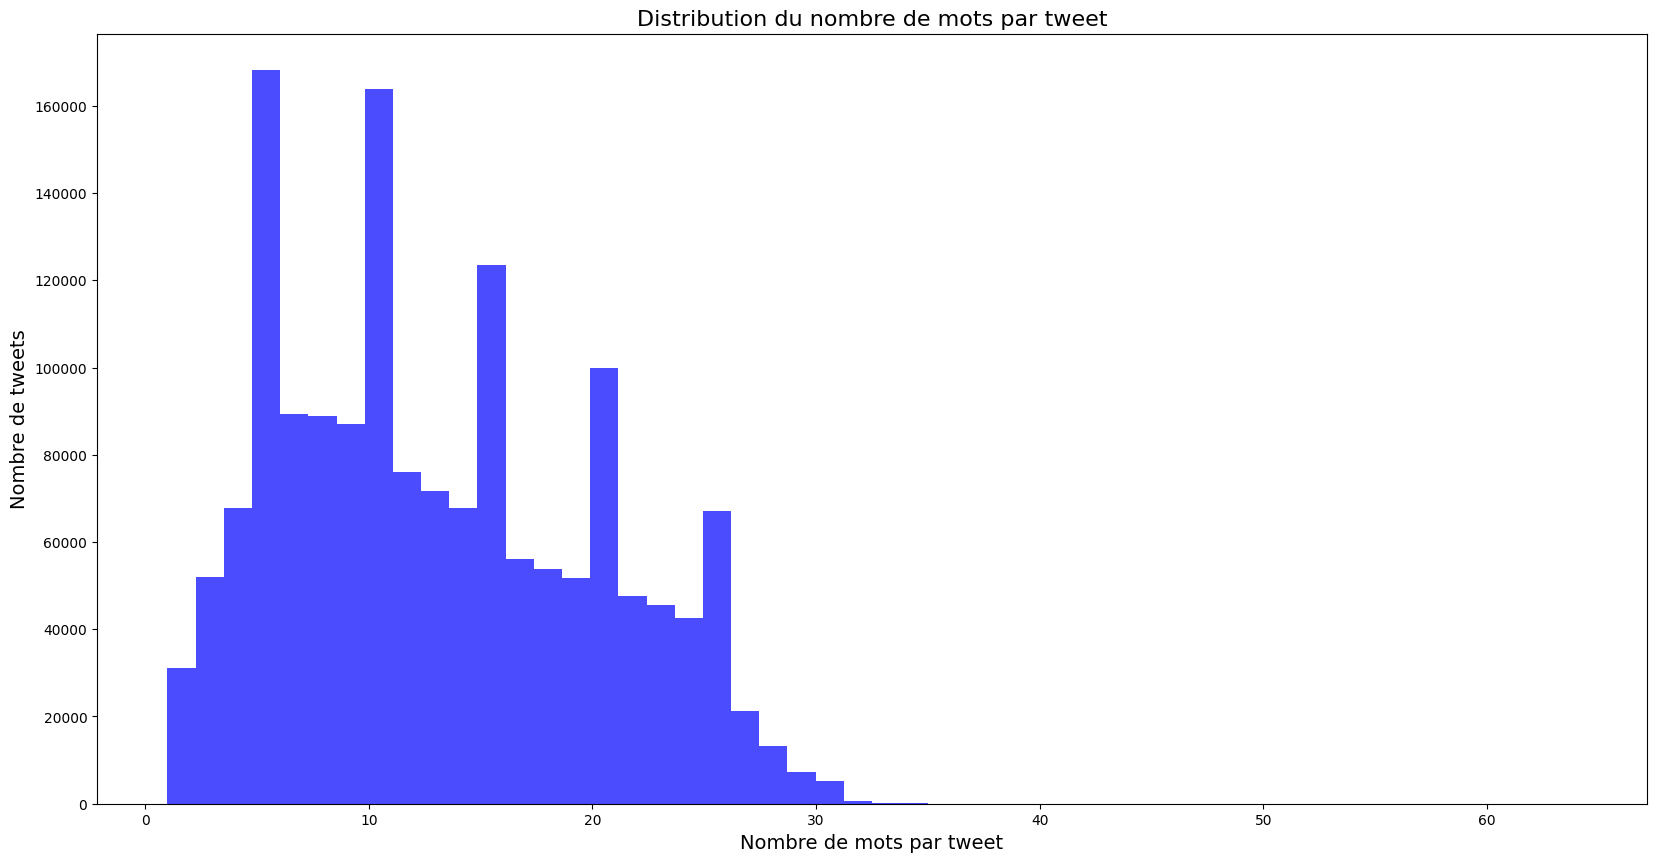

In [14]:
# --- Analyse de la distribution du nombre de mots par tweet ---

# Création d'une figure avec une taille adaptée
plt.figure(figsize=(20, 10))

# Création de l'histogramme de la distribution du nombre de mots dans les tweets
plt.hist(
    data["text"].apply(lambda x: len(x.split())),  # Calcul du nombre de mots par tweet
    bins=50,  # Nombre de bins pour affiner la distribution
    color="blue",  # Couleur des barres pour une meilleure visibilité
    alpha=0.7  # Transparence pour améliorer la lisibilité
)

# Ajout de titres et labels pour une meilleure compréhension
plt.title("Distribution du nombre de mots par tweet", fontsize=16)
plt.xlabel("Nombre de mots par tweet", fontsize=14)
plt.ylabel("Nombre de tweets", fontsize=14)

# Affichage du graphique
plt.show()


In [15]:
# --- Suite de l'analyse de la distribution du nombre de mots par tweet ---

# Calcul du nombre de mots dans chaque tweet
tweet_word_counts = data["text"].apply(lambda x: len(x.split()))

# Affichage des statistiques sur le nombre de mots par tweet
print(f"📊 Statistiques sur le nombre de mots par tweet :")
print(f"▶ Moyenne  : {tweet_word_counts.mean():.2f} mots")  # Moyenne du nombre de mots par tweet
print(f"▶ Médiane  : {tweet_word_counts.median():.2f} mots")  # Médiane pour observer la tendance centrale
print(f"▶ Max      : {tweet_word_counts.max()} mots")  # Nombre maximum de mots dans un tweet
print(f"▶ Min      : {tweet_word_counts.min()} mots")  # Nombre minimum de mots dans un tweet


📊 Statistiques sur le nombre de mots par tweet :
▶ Moyenne  : 13.18 mots
▶ Médiane  : 12.00 mots
▶ Max      : 64 mots
▶ Min      : 1 mots


**<u>Commentaire :</u>**

L'analyse univariée nous permet déjà faire quelques remarques :
-  Notre cible à 2 valeurs : 0 (négatif) ou 4 (positif)
-  il semble y avoir des ids en double
-  la colonne date ne sera pas utile pour notre classification
-  la colonne flag comporte une seule valeurs, nous pouvons la supprimer
-  user, indique le nom d'utilisateur mais non pertinent pour notre projet
-  text, correspond au tweet écrit par l'utilisateur

Passons à l'analyse multivariée.

### **B. Analyse multivariée**

#### **1. Relation entre la longueur des tweets et le sentiment**

**<u>Commentaire :</u>**

Objectif : Vérifier si les tweets négatifs sont plus longs ou plus courts que les tweets positifs.

In [16]:
# --- Préparation des données ---

# Création d'une colonne texte pour mieux comprendre la variable cible (0 = Négatif, 4 = Positif)
data["target_text"] = data["target"].replace({0: "Négatif", 4: "Positif"})

# Création d'une colonne pour stocker la longueur des tweets (nombre de caractères)
data["tweet_length"] = data["text"].apply(len)

# Affichage des premières lignes du dataset pour vérifier les modifications
data.head()

,target,ids,date,flag,user,text,target_text,tweet_length
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Négatif,115
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Négatif,111
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Négatif,89
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Négatif,47
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Négatif,111


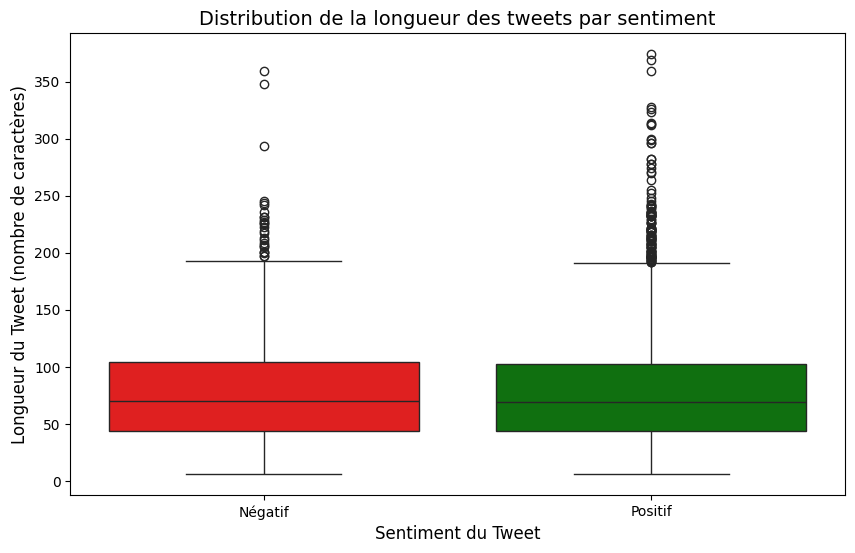

In [17]:
# --- Visualisation avec un boxplot ---

# Définition de la taille de la figure pour une meilleure lisibilité
plt.figure(figsize=(10, 6))

# Création du boxplot pour comparer la longueur des tweets en fonction du sentiment
sns.boxplot(x="target_text", y="tweet_length", data=data, hue="target_text", palette={"Négatif": "red", "Positif": "green"}, legend=False)

# Ajout des labels et du titre pour améliorer la compréhension du graphique
plt.xlabel("Sentiment du Tweet", fontsize=12)
plt.ylabel("Longueur du Tweet (nombre de caractères)", fontsize=12)
plt.title("Distribution de la longueur des tweets par sentiment", fontsize=14)

# Affichage du graphique
plt.show()

In [18]:
# --- Affichage des statistiques générales sur la longueur des tweets ---

# Calcul des statistiques globales
print(f"📊 Statistiques globales sur la longueur des tweets :")
print(f"▶ Moyenne  : {data['tweet_length'].mean():.2f} caractères")
print(f"▶ Médiane  : {data['tweet_length'].median():.2f} caractères")
print(f"▶ Max      : {data['tweet_length'].max()} caractères")
print(f"▶ Min      : {data['tweet_length'].min()} caractères")
print(f"▶ Écart-type : {data['tweet_length'].std():.2f} caractères")


📊 Statistiques globales sur la longueur des tweets :
▶ Moyenne  : 74.09 caractères
▶ Médiane  : 69.00 caractères
▶ Max      : 374 caractères
▶ Min      : 6 caractères
▶ Écart-type : 36.44 caractères


In [19]:
# --- Segmentation des statistiques par sentiment (positif vs négatif) ---

print("\n📊 Statistiques par sentiment :")

# Calcul des statistiques principales sauf la médiane
stats_by_sentiment = data.groupby("target_text")["tweet_length"].agg(["mean", "min", "max", "std"])

# Ajout manuel de la médiane (car non incluse dans describe())
stats_by_sentiment["median"] = data.groupby("target_text")["tweet_length"].median()

# Réorganisation des colonnes pour un affichage logique
stats_by_sentiment = stats_by_sentiment[["mean", "median", "min", "max", "std"]]

# Affichage des résultats sous forme de tableau 
display(stats_by_sentiment)


📊 Statistiques par sentiment :


,mean,median,min,max,std
target_text,,,,,
Négatif,74.301790,70.0,6,359,36.743260
Positif,73.878433,69.0,6,374,36.135274


**<u>Commentaire :</u>**

Nous pouvons déduire qu'il n'y a pas de corrélation entre la longueur du tweet et le sentiment.

#### **2. Fréquence des mots en fonction du sentiment**

**<u>Commentaire :</u>**

Objectif : Identifier les mots les plus fréquents dans les tweets positifs et négatifs.

In [20]:
# --- Séparation des tweets positifs et négatifs ---

# Extraction des textes des tweets en fonction du sentiment
tweets_negatifs = data[data["target_text"] == "Négatif"]["text"]
tweets_positifs = data[data["target_text"] == "Positif"]["text"]

# Vérification du nombre de tweets dans chaque catégorie
print(f"Nombre de tweets négatifs : {len(tweets_negatifs)}")
print(f"Nombre de tweets positifs : {len(tweets_positifs)}")


Nombre de tweets négatifs : 800000
Nombre de tweets positifs : 800000


In [21]:
# --- Fonction pour extraire les mots les plus fréquents ---

def get_top_words(tweets, n=20):
    # Vérification que la liste des tweets n'est pas vide
    if tweets.empty:
        print("Aucun tweet disponible pour l'analyse.")
        return []

    vectorizer = CountVectorizer(stop_words="english")  # Suppression des mots vides (anglais)
    
    try:
        word_matrix = vectorizer.fit_transform(tweets)  # Transformation des tweets en matrice de mots
        word_counts = np.array(word_matrix.sum(axis=0)).flatten()  # Comptage des occurrences des mots
        words_freq = list(zip(vectorizer.get_feature_names_out(), word_counts))  # Association mot/fréquence
        words_freq_sorted = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]  # Tri des mots par fréquence
        
        return words_freq_sorted
    
    except ValueError:
        print("Problème lors de la vectorisation des tweets (vocabulaire vide).")
        return []


In [22]:
# --- Classement des mots les plus fréquents par sentiment ---

# Extraction des mots les plus fréquents
top_words_neg = get_top_words(tweets_negatifs)
top_words_pos = get_top_words(tweets_positifs)

# Conversion en DataFrame pour affichage
df_top_words_neg = pd.DataFrame(top_words_neg, columns=["Mot", "Fréquence"])
df_top_words_pos = pd.DataFrame(top_words_pos, columns=["Mot", "Fréquence"])

# Affichage des résultats
if not df_top_words_neg.empty:
    tools.display_dataframe_to_user(name="Top 20 mots - Tweets Négatifs", dataframe=df_top_words_neg)

if not df_top_words_pos.empty:
    tools.display_dataframe_to_user(name="Top 20 mots - Tweets Positifs", dataframe=df_top_words_pos)

Top 20 mots - Tweets Négatifs


Top 20 mots - Tweets Positifs


**<u>Commentaire :</u>**

Certains mots sont similaires pour les deux types de sentiments, affichons un nuages de mots pour chaque sentiments pour mieux voir la différence.

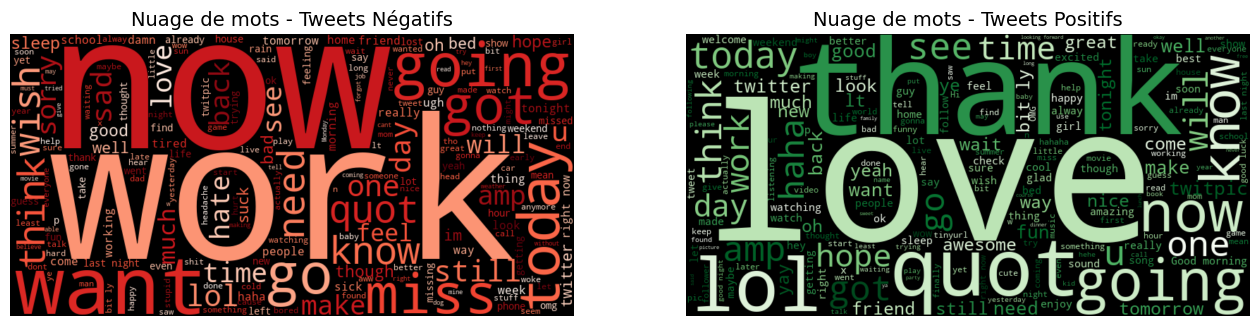

In [23]:
# --- Visualisation avec des nuages de mots ---

# Générer un nuage de mots pour les tweets négatifs
text_neg = " ".join(tweets_negatifs)
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(text_neg)

# Générer un nuage de mots pour les tweets positifs
text_pos = " ".join(tweets_positifs)
wordcloud_pos = WordCloud(width=800, height=400, background_color="black", colormap="Greens").generate(text_pos)

# Configuration des wordclouds
plt.figure(figsize=(16, 8))

# Wordcloud des tweets négatifs
plt.subplot(1, 2, 1)  # Première position dans une grille de 1 ligne, 2 colonnes
plt.imshow(wordcloud_neg, interpolation="bilinear")  # Adoucit le rendu des lettres
plt.axis("off")  # Supprime les axes pour une meilleure lisibilité
plt.title("Nuage de mots - Tweets Négatifs", fontsize=14)  # Ajoute un titre clair au graphique

# Wordcloud des tweets positifs
plt.subplot(1, 2, 2)  # Deuxième position dans la même grille de 1 ligne, 2 colonnes
plt.imshow(wordcloud_pos, interpolation="bilinear")  # Adoucit le rendu des lettres
plt.axis("off")  # Supprime les axes pour garder un affichage propre
plt.title("Nuage de mots - Tweets Positifs", fontsize=14)  # Ajoute un titre clair au graphique

# Afficher les graphiques
plt.show()


**<u>Commentaire :</u>**

On remarque 2 mots phares :
-  pour les tweets négatifs : **work** et **now**, donc pouvant être liés à de l'anxiété, une surcharger etc..
-  pour les tweets positifs : **thank** et **love**, le remerciement et l'amour.

On voit ainsi qu'il y a bien une différence dans la fréquence des mots selon le sentiment.

## **3. Nettoyage**

**<u>Commentaire :</u>**

Nous allons corriger les problèmes de doublons, de colonnes inutiles, de valeurs etc..

### **A. Doublons**

In [24]:
# Vérifier le nombre de doublons dans la colonne 'id'
nb_doublons = data.duplicated(subset=['ids']).sum()
print(f"Nombre de doublons dans la colonne 'ids' : {nb_doublons}")


Nombre de doublons dans la colonne 'ids' : 1685


In [25]:
data[data.duplicated(subset=['ids'], keep=False)]

,target,ids,date,flag,user,text,target_text,tweet_length
213,0,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...,Négatif,142
275,0,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...,Négatif,96
989,0,1468053611,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,mariejamora,@hellobebe I also send some updates in plurk b...,Négatif,126
1177,0,1468100580,Mon Apr 06 23:42:57 PDT 2009,NO_QUERY,cristygarza,good night swetdreamss to everyonee and jare...,Négatif,72
1254,0,1468115720,Mon Apr 06 23:48:00 PDT 2009,NO_QUERY,WarholGirl,@ientje89 aw i'm fine too thanks! yeah i miss ...,Négatif,123
...,...,...,...,...,...,...,...,...
1598780,4,2193278017,Tue Jun 16 08:14:22 PDT 2009,NO_QUERY,janiecwales,oh dear HH is back please twitter do somethi...,Positif,99
1599298,4,2193403830,Tue Jun 16 08:24:44 PDT 2009,NO_QUERY,lauren__x33,english exam went okay revising for fre...,Positif,80
1599385,4,2193428118,Tue Jun 16 08:26:44 PDT 2009,NO_QUERY,bubbles00,"finally finished typing!!!! Woohoooo , still ...",Positif,72
1599440,4,2193451289,Tue Jun 16 08:28:37 PDT 2009,NO_QUERY,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo...",Positif,101


In [26]:
# Filtrer les lignes sur un ID en double
id_value = 1467863684
filtered_data = data[data['ids'] == id_value]

# Afficher le résultat
display(filtered_data)

,target,ids,date,flag,user,text,target_text,tweet_length
213,0,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...,Négatif,142
800261,4,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...,Positif,142


In [27]:
# Filtrer les lignes sur un autre ID en double
id_value = 1467880442
filtered_data = data[data['ids'] == id_value]

# Afficher le résultat
display(filtered_data)

,target,ids,date,flag,user,text,target_text,tweet_length
275,0,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...,Négatif,96
800300,4,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...,Positif,96


**<u>Commentaire :</u>**

Il y a effectivement des doublons, mais dont l'annotation est mauvaise ! Car à la fois positif et négatif !
Nous ne pouvons pas prendre ces données en compte, car nous ne sommes pas sur du sentiment derrière, nous les supprimons.

In [28]:
# Trouver les IDs en double
duplicated_ids = data['ids'].value_counts()
ids_to_remove = duplicated_ids[duplicated_ids > 1].index  # Sélectionne uniquement les ID ayant plus d'une occurrence

# Supprimer toutes les lignes contenant ces ID
data = data[~data['ids'].isin(ids_to_remove)]

# Vérification après suppression
print(f"Nombre total de lignes après suppression : {data.shape[0]}")


Nombre total de lignes après suppression : 1596630


In [29]:
# Vérifier doublons
print(f"Nombre de doublons restants : {data.duplicated(subset=['ids']).sum()}")

Nombre de doublons restants : 0


**<u>Commentaire :</u>**

Doublons supprimés.

### **B. Suppressions des variables inutiles pour la modélisation**

In [30]:
# Suppression des colonnes inutiles
data.drop(['ids', 'date', 'flag', 'user', 'target_text', 'tweet_length'], axis=1, inplace=True)

In [31]:
# check
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [32]:
# Afficher les dimensions de notre DataFrame
nb_individus = data.shape[0]
nb_variables = data.shape[1]
display(Markdown(f"Le jeu de données contient désormais **{nb_individus} individus** (lignes) et **{nb_variables} variables** (colonnes)."))

Le jeu de données contient désormais **1596630 individus** (lignes) et **2 variables** (colonnes).

In [33]:
# Afficher les valeurs en texte.
nb_tweet = f"Le dataset contient {target_counts.iloc[0]} tweets avec le target {target_counts.index[0]} et {target_counts.iloc[1]} tweets avec le target {target_counts.index[1]}."

# Afficher la phrase
print(nb_tweet)


Le dataset contient 800000 tweets avec le target 0 et 800000 tweets avec le target 4.


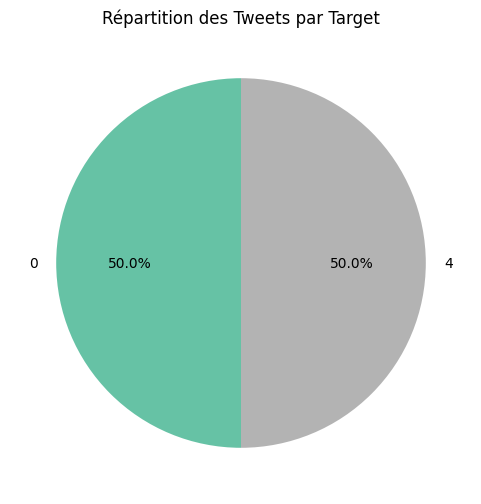

In [34]:
# pie chart

# Création du graphique
plt.figure(figsize=(6, 6))
data['target'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set2')

# Ajout du titre
plt.title("Répartition des Tweets par Target")

# Affichage
plt.ylabel("")  # Enlever le label y
plt.show()


**<u>Commentaire :</u>**

Notre jeu de données est donc équilibré.

### **C. Transformer la Target en binaire**

In [35]:
# Vérifier les valeurs de target AVANT traitement
print(data["target"].value_counts())

target
0    798315
4    798315
Name: count, dtype: int64


In [36]:
# Convertir target en binaire (si nécessaire)
data["target"] = data["target"].apply(lambda x: 1 if x == 4 else 0)  # Ex: 4 = positif, 0 = négatif

In [37]:
# Vérifier les valeurs de target APRES traitement
print(data["target"].value_counts())

target
0    798315
1    798315
Name: count, dtype: int64


### **D. Echantillonage**

**<u>Commentaire :</u>**

Pour accélérer l'entrainement des modèles, nous allons conserver 10% des tweets, soit près de 160 000 tweets, ce qui est amplement suffisant.

In [38]:
# --- Réduction de l'échantillon avec stratification ---

# Sélectionner 10% des données en conservant la répartition originale des classes
data_reduced, _ = train_test_split( # On ne récupère que la partie train : data_reduced, le _ sert à ignorer la partie test : unused_data (90% des données qui sont écartées).
    data,  # Jeu de données initial
    test_size=0.9,  # 90% des données seront mises de côté (non utilisées)
    stratify=data['target'],  # Maintien de la proportion des classes
    random_state=42  # Fixe l'aléatoire pour rendre les résultats reproductibles
)

# --- Vérification des proportions avant et après la réduction ---

# Calcul de la distribution des classes avant et après
class_distribution_original = data['target'].value_counts(normalize=True) * 100  # % des classes dans l'ensemble original
class_distribution_reduced = data_reduced['target'].value_counts(normalize=True) * 100  # % des classes après réduction

# Affichage des résultats
print("📊 Répartition des classes avant réduction :")
print(class_distribution_original)

print("\n📉 Répartition des classes après réduction :")
print(class_distribution_reduced)

📊 Répartition des classes avant réduction :
target
0    50.0
1    50.0
Name: proportion, dtype: float64

📉 Répartition des classes après réduction :
target
1    50.000313
0    49.999687
Name: proportion, dtype: float64


### **E. Prétraitement des tweets**

**<u>Commentaire :</u>**

Le prétraitement consiste à nettoyer et normaliser le texte.
Pour notre projet, nous allons utiliser plusieurs approches, il faut donc adapter notre nettoyage. Pour cela nous allons effectuer un nettoyage de base, valable pour toutes les approches, puis nous ajouterons des traitements spécifiques si nécessaire.

Voici un tableau qui résume l'utilisation du nettoyage :



| Approche | Ponctuation & Chiffres | URLs & Mentions | Hashtags | Stopwords | Lemmatisation | Tokenisation | Padding | Tokenisation BERT |
|----------|------------------|---------------|----------|----------|--------------|-------------|---------|----------------|
| **TF-IDF + Régression Logistique** | ✅ À supprimer | ✅ À supprimer | ✅ À supprimer | 🔹 À tester (souvent bénéfique) | 🔹 À tester (peut améliorer) | ❌ Non nécessaire | ❌ Non nécessaire | ❌ Non nécessaire |
| **Word Embeddings (Word2Vec, GloVe, FastText) + LSTM/GRU** | ✅ À supprimer | ✅ À supprimer | ✅ À supprimer | ❌ Ne pas supprimer (les embeddings ont besoin du contexte complet) | ❌ Pas nécessaire (les embeddings sont déjà optimisés) | ✅ Obligatoire | ✅ Obligatoire | ❌ Non nécessaire |
| **BERT** | ✅ À supprimer | ✅ À supprimer | ✅ À supprimer | ❌ Ne pas supprimer (les stopwords ont un rôle dans le contexte) | ❌ Pas nécessaire (BERT comprend les mots sous leur forme correcte) | ✅ Obligatoire (BERT Tokenizer) | ✅ Obligatoire | ✅ Obligatoire |


In [39]:
# --- Prétraitement des données ---

# Fonction de base pour tous les modèles
def clean_text_base(text):
    text = text.lower()  # Conversion en minuscules
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Suppression des URLs
    text = re.sub(r'@\w+', '', text)  # Suppression des mentions
    text = re.sub(r'#\w+', '', text)  # Suppression des hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Suppression de la ponctuation et des chiffres
    text = re.sub(r'\s+', ' ', text).strip()  # Suppression des espaces multiples
    return text


## **4. Modélisation**

### **A. Modèle sur mesure simple : TF-IDF avec Régression logistique**

**<u>Commentaire :</u>**

Pour le modèle simple, nous allons tester deux approches :
-  SANS StopWords et SANS Lemmatisation
-  AVEC StopWords et AVEC Lemmatisation

Puis nous comparerons les résultats pour voir le plus efficace.

#### **SANS enlever StopWords et SANS enlever Lemmatisation**

In [40]:
# --- Modèle sans suppression des stopwords et sans lemmatisation partie 1/2 ---

# Nettoyage de base
data_reduced['clean_text_base'] = data_reduced['text'].apply(clean_text_base)

# Créer une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer le vectoriseur sur la colonne 'clean_text_base'
X_tfidf = vectorizer.fit_transform(data_reduced['clean_text_base'])
y = data_reduced['target'] # Variable cible

# Afficher les dimensions de la matrice de caractéristiques
print("Dimensions de la matrice de caractéristiques :", X_tfidf.shape)


Dimensions de la matrice de caractéristiques : (159663, 85927)


In [41]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()

,target,text,clean_text_base
60400,0,had a productive cleaning day yesterday but my...,had a productive cleaning day yesterday but my...
397317,0,i just noticed that the world is filled with l...,i just noticed that the world is filled with l...
465261,0,Hey it is Matt. Waiting for Jen to fall on her...,hey it is matt waiting for jen to fall on her ...
591559,0,@cawanpink,
1264074,1,Im following a few pointless twitters.. Why?? ...,im following a few pointless twitters why idk ...


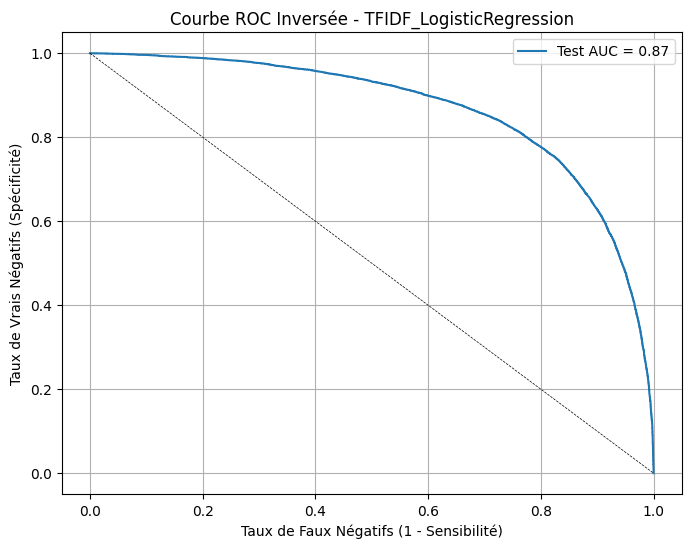

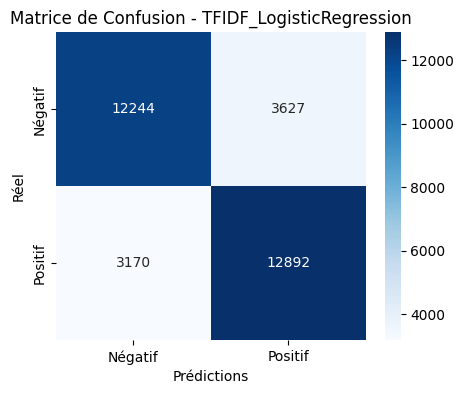


=== 📊 Tableau des performances ===
  Performance      Test
0    Accuracy  0.787148
1   Precision  0.780435
2      Recall  0.802640
3    F1 Score  0.791381


In [42]:
# --- Modèle sans suppression des stopwords et sans lemmatisation partie 2/2 ---

# Enregistrer les performances du modèle dans MLFlow
mlflow.set_experiment("Détection des Bad Buzz")

with mlflow.start_run(run_name="TF_IDF_Sans_Stopwords_Lemmatisation"):

    # Définition du dossier de stockage des artefacts
    model_name = "TFIDF_LogisticRegression"  # Nom spécifique du modèle
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)  # Crée le dossier s'il n'existe pas

    # Log des paramètres du Vectorizer
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("vectorizer_ngram_range", vectorizer.ngram_range)
    
    # Diviser les données en ensembles d'entraînement et de test de façon stratifiée
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # Entraînement du modèle de Régression Logistique
    model_base = LogisticRegression()
    mlflow.log_param("solver", model_base.solver) 
    mlflow.log_param("penalty", model_base.penalty)  
    model_base.fit(X_train, y_train)

    # Prédictions
    y_train_pred_proba = model_base.predict_proba(X_train)[:, 1] # Proba = classe 1 (positif), utilisé pour la courbe ROC & AUC
    y_test_pred_proba = model_base.predict_proba(X_test)[:, 1] # Proba = classe 1 (positif), utilisé pour la courbe ROC & AUC
    y_train_pred_proba_neg = model_base.predict_proba(X_train)[:, 0] # Proba = classe 0 (négatif), utilisé pour la courbe ROC & AUC
    y_test_pred_proba_neg = model_base.predict_proba(X_test)[:, 0] # Proba = classe 0 (négatif), utilisé pour la courbe ROC & AUC
    y_pred_base = model_base.predict(X_test) # Prédictions finales (0 ou 1), utilisé pour la matrice de confusion et les scores d'évaluation

    # Calcul des métriques générales
    test_accuracy = accuracy_score(y_test, y_pred_base) # Score global sur le test

    # Précision = % de prédictions positives correctes
    test_precision = precision_score(y_test, y_pred_base)

    # Rappel = % de cas positifs bien détectés
    test_recall = recall_score(y_test, y_pred_base)

    # F1-score = équilibre entre précision et rappel
    test_f1 = f1_score(y_test, y_pred_base)

    # Courbe ROC pour les tweets positifs (classe 1)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    # Calcul de l'AUC pour la classe positive
    auc_test = auc(fpr_test, tpr_test)  # Aire sous la courbe ROC pour le test

    # Courbe ROC pour les tweets négatifs (classe 0)
    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test, y_test_pred_proba_neg)

    # Calcul de l'AUC pour la classe négative (bad buzz)
    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)

    # Tracé et enregistrement de la courbe ROC Inversée
    roc_path = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5) # Diagonale inversée de référence
    plt.xlabel('Taux de Faux Négatifs (1 - Sensibilité)')
    plt.ylabel('Taux de Vrais Négatifs (Spécificité)')
    plt.title(f'Courbe ROC Inversée - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(roc_path)  # Enregistrement dans le dossier
    mlflow.log_artifact(roc_path)  # Ajout dans MLflow
    plt.show()

    # Matrice de confusion
    conf_matrix_base = confusion_matrix(y_test, y_pred_base)

    conf_matrix_path = os.path.join(artifact_dir, "conf_matrix.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues', xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path)  # Enregistrement
    mlflow.log_artifact(conf_matrix_path)  # Ajout dans MLflow
    plt.show()

    # Tableau des performances
    performance_table = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== 📊 Tableau des performances ===")
    print(performance_table)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Exemple d'entrée basé sur les données d'entraînement
    input_example = X_train[0].toarray().reshape(1, -1) 

    # Enregistrement du modèle avec un input_example
    mlflow.sklearn.log_model(model_base, "model_TF_IDF", input_example=input_example)

**<u>Commentaire :</u>**

**Nous ne traçons pas une courbe ROC standard, mais une courbe inversée pour les bad buzz**.

👉 Dans une courbe ROC standard :
-  Axe X = Taux de Faux Positifs (1 - Spécificité)
-  Axe Y = Taux de Vrais Positifs (Sensibilité)
-  Une bonne courbe tend vers le coin supérieur gauche (0,1).

👉 Dans une courbe ROC inversée (pour les bad buzz) :
-  Axe X = Taux de Faux Négatifs (1 - Sensibilité)
-  Axe Y = Taux de Vrais Négatifs (Spécificité)
-  Une bonne courbe doit tendre vers le coin supérieur droit (1,1).

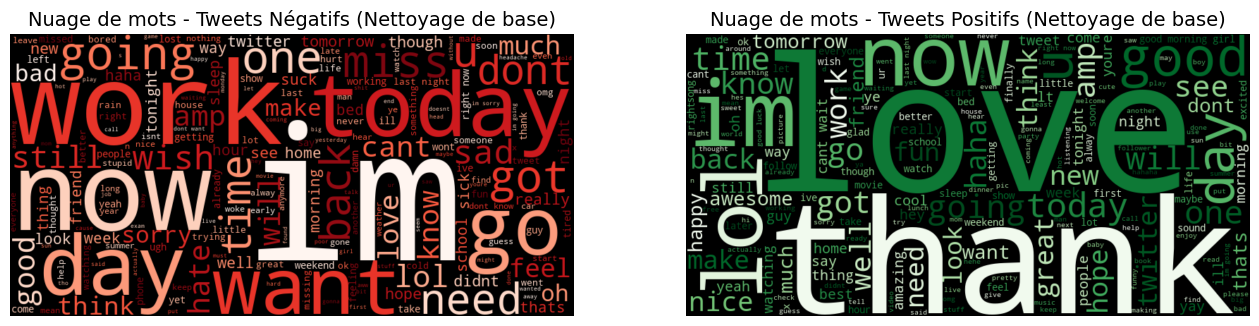

In [43]:
# --- MAJ des nuages de mots ---

# Séparer les tweets négatifs et positifs (Nettoyage de base)
tweets_neg_base = " ".join(data_reduced[data_reduced['target'] == 0]['clean_text_base'])
tweets_pos_base = " ".join(data_reduced[data_reduced['target'] == 1]['clean_text_base'])

# Générer les wordclouds
wordcloud_neg_base = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(tweets_neg_base)
wordcloud_pos_base = WordCloud(width=800, height=400, background_color="black", colormap="Greens").generate(tweets_pos_base)

# Affichage des wordclouds
plt.figure(figsize=(16, 8))

# Wordcloud des tweets négatifs (Nettoyage de base)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg_base, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets Négatifs (Nettoyage de base)", fontsize=14)

# Wordcloud des tweets positifs (Nettoyage de base)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pos_base, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets Positifs (Nettoyage de base)", fontsize=14)

# Affichage des graphiques
plt.show()


**<u>Commentaire :</u>**



#### **AVEC StopWords effectué et AVEC Lemmatisation effectué**

**<u>Commentaire :</u>**



In [44]:
# --- Prétraitement des données avancé ---

# Fonction complémentaire pour enlever stopwords et ajouté lemmatisation
def clean_text_advanced(text):
    text = clean_text_base(text)  # Nettoyage de base

    # Suppression des stopwords
    stop_words = set(stopwords.words("english"))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text


In [45]:
# --- Modèle sans suppression des stopwords et sans lemmatisation partie 1/2 ---

# Nettoyage avancé
data_reduced['text_tf_advanced'] = data_reduced['text'].apply(clean_text_advanced)

# Créer une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer le vectoriseur sur la colonne 'clean_text_base'
X_tfidf_advanced = vectorizer.fit_transform(data_reduced['text_tf_advanced'])
y = data_reduced['target'] # Variable cible

# Afficher les dimensions de la matrice de caractéristiques
print("Dimensions de la matrice de caractéristiques :", X_tfidf.shape)


Dimensions de la matrice de caractéristiques : (159663, 85927)


In [46]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()

,target,text,clean_text_base,text_tf_advanced
60400,0,had a productive cleaning day yesterday but my...,had a productive cleaning day yesterday but my...,productive cleaning day yesterday shoulder pay...
397317,0,i just noticed that the world is filled with l...,i just noticed that the world is filled with l...,noticed world filled lot o amatuears moron srr...
465261,0,Hey it is Matt. Waiting for Jen to fall on her...,hey it is matt waiting for jen to fall on her ...,hey matt waiting jen fall butt damn texting je...
591559,0,@cawanpink,,
1264074,1,Im following a few pointless twitters.. Why?? ...,im following a few pointless twitters why idk ...,im following pointless twitter idk must change...


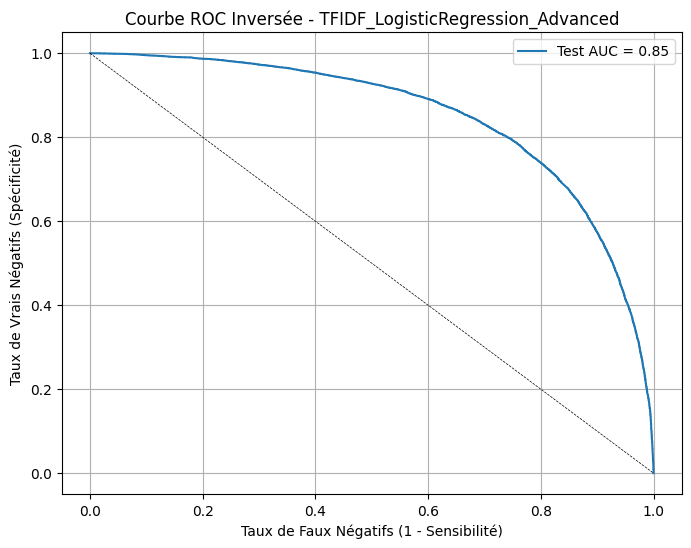

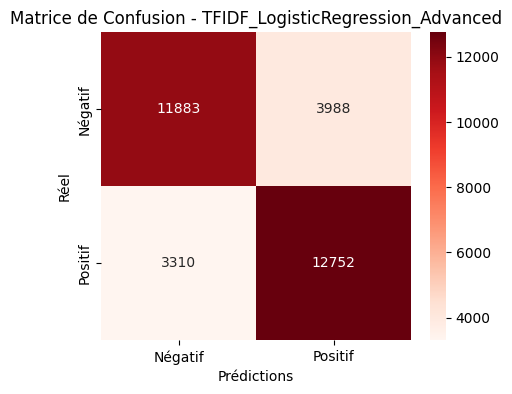


=== 📊 Tableau des performances ===
  Performance      Test
0    Accuracy  0.771459
1   Precision  0.761768
2      Recall  0.793924
3    F1 Score  0.777514


In [47]:
# --- Modèle avec suppression des stopwords et lemmatisation partie 2/2 ---

# Enregistrer les performances du modèle dans MLFlow
mlflow.set_experiment("Détection des Bad Buzz")

with mlflow.start_run(run_name="TF_IDF_Avec_Stopwords_Lemmatisation"):

    # Définition du dossier de stockage des artefacts
    model_name = "TFIDF_LogisticRegression_Advanced"  # Nom spécifique du modèle
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)  # Crée le dossier s'il n'existe pas

    # Log des paramètres du Vectorizer
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("vectorizer_ngram_range", vectorizer.ngram_range)
    
    # Séparation en train/test
    X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_tfidf_advanced, y, test_size=0.2, random_state=42)

    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # Entraînement du modèle de Régression Logistique
    model_advanced = LogisticRegression()
    mlflow.log_param("solver", model_advanced.solver) 
    mlflow.log_param("penalty", model_advanced.penalty) 
    model_advanced.fit(X_train_adv, y_train_adv)

    # Prédictions
    y_train_pred_proba_adv = model_advanced.predict_proba(X_train_adv)[:, 1]  # Proba = classe 1 (positif)
    y_test_pred_proba_adv = model_advanced.predict_proba(X_test_adv)[:, 1]  # Proba = classe 1 (positif)
    y_train_pred_proba_neg_adv = model_advanced.predict_proba(X_train_adv)[:, 0]  # Proba = classe 0 (négatif)
    y_test_pred_proba_neg_adv = model_advanced.predict_proba(X_test_adv)[:, 0]  # Proba = classe 0 (négatif)
    y_pred_adv = model_advanced.predict(X_test_adv)  # Prédictions finales

    # Calcul des métriques générales
    test_accuracy_adv = accuracy_score(y_test_adv, y_pred_adv)

    # Précision = % de prédictions positives correctes
    test_precision_adv = precision_score(y_test_adv, y_pred_adv)

    # Rappel = % de cas positifs bien détectés
    test_recall_adv = recall_score(y_test_adv, y_pred_adv)

    # F1-score = équilibre entre précision et rappel
    test_f1_adv = f1_score(y_test_adv, y_pred_adv)

    # Courbe ROC pour les tweets positifs (classe 1)
    fpr_test_adv, tpr_test_adv, _ = roc_curve(y_test_adv, y_test_pred_proba_adv)

    # Calcul de l'AUC pour la classe positive
    auc_test_adv = auc(fpr_test_adv, tpr_test_adv)

    # Courbe ROC pour les tweets négatifs (classe 0)
    fpr_test_neg_adv, tpr_test_neg_adv, _ = roc_curve(y_test_adv, y_test_pred_proba_neg_adv)

    # Calcul de l'AUC pour la classe négative (bad buzz)
    auc_test_neg_adv = auc(fpr_test_neg_adv, tpr_test_neg_adv)

    # Tracé et enregistrement de la courbe ROC Inversée
    roc_path_adv = os.path.join(artifact_dir, "roc_curve_bad_buzz_advanced.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg_adv, 1 - tpr_test_neg_adv, label=f'Test AUC = {1 - auc_test_neg_adv:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux Négatifs (1 - Sensibilité)')
    plt.ylabel('Taux de Vrais Négatifs (Spécificité)')
    plt.title(f'Courbe ROC Inversée - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(roc_path_adv)
    mlflow.log_artifact(roc_path_adv)
    plt.show()

    # Matrice de confusion
    conf_matrix_adv = confusion_matrix(y_test_adv, y_pred_adv)

    conf_matrix_path_adv = os.path.join(artifact_dir, "conf_matrix_advanced.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_adv, annot=True, fmt='d', cmap='Reds', xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_adv)
    mlflow.log_artifact(conf_matrix_path_adv)
    plt.show()

    # Tableau des performances
    performance_table_adv = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy_adv, test_precision_adv, test_recall_adv, test_f1_adv]
    })

    print("\n=== 📊 Tableau des performances ===")
    print(performance_table_adv)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy_adv)
    mlflow.log_metric("Test Precision", test_precision_adv)
    mlflow.log_metric("Test Recall", test_recall_adv)
    mlflow.log_metric("Test F1 Score", test_f1_adv)
    mlflow.log_metric("Test AUC", auc_test_adv)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg_adv)

    # Enregistrement du modèle
    input_example_adv = X_train_adv[0].toarray().reshape(1, -1) 
    mlflow.sklearn.log_model(model_advanced, "model_TF_IDF_ADV", input_example=input_example_adv)


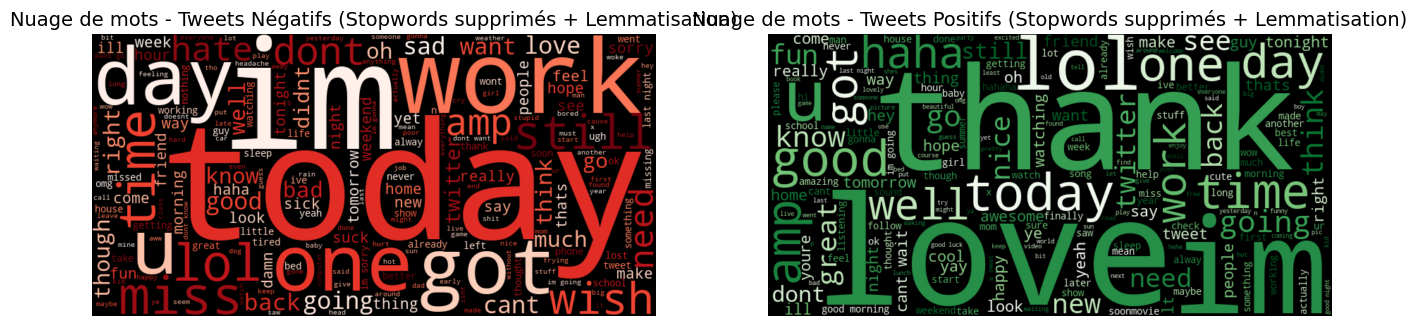

In [48]:
# --- MAJ des nuages de mots ---

# Séparer les tweets négatifs et positifs (Nettoyage avancé)
tweets_neg_adv = " ".join(data_reduced[data_reduced['target'] == 0]['text_tf_advanced'])
tweets_pos_adv = " ".join(data_reduced[data_reduced['target'] == 1]['text_tf_advanced'])

# Générer les wordclouds
wordcloud_neg_adv = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(tweets_neg_adv)
wordcloud_pos_adv = WordCloud(width=800, height=400, background_color="black", colormap="Greens").generate(tweets_pos_adv)

# Affichage des wordclouds
plt.figure(figsize=(16, 8))

# Wordcloud des tweets négatifs (Nettoyage avancé)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg_adv, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets Négatifs (Stopwords supprimés + Lemmatisation)", fontsize=14)

# Wordcloud des tweets positifs (Nettoyage avancé)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_pos_adv, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets Positifs (Stopwords supprimés + Lemmatisation)", fontsize=14)

# Affichage des graphiques
plt.show()


Recall sur les tweets négatifs (bad buzz) : Capacité du modèle à bien détecter les tweets négatifs.
🔹 Recall (Sans Stopwords & Lemmatisation) : 0.7715
🔹 Recall (Avec Stopwords & Lemmatisation) : 0.7487

AUC sur la classe négative : Pour voir si le modèle discrimine bien les tweets négatifs.
🔹 AUC Bad Buzz (Sans Stopwords & Lemmatisation) : 0.8657
🔹 AUC Bad Buzz (Avec Stopwords & Lemmatisation) : 0.8496

F1-score sur les tweets négatifs : Compromis entre rappel et précision pour éviter les faux négatifs.
🔹 F1-score Bad Buzz (Sans Stopwords & Lemmatisation) : 0.7827
🔹 F1-score Bad Buzz (Avec Stopwords & Lemmatisation) : 0.7651


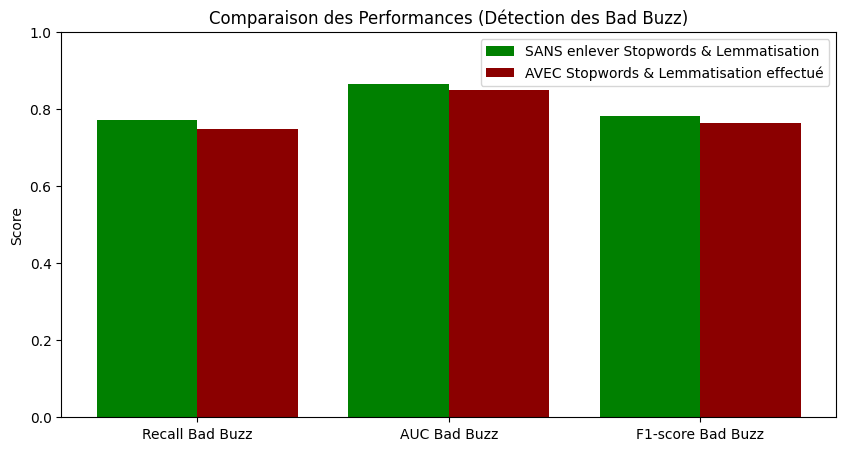

In [49]:
# --- Comparaison des modèles (Détection des bad buzz) ---

# Comparaison du rappel sur les tweets négatifs (priorité du projet)
recall_base = recall_score(y_test, y_pred_base, pos_label=0)
recall_adv = recall_score(y_test_adv, y_pred_adv, pos_label=0)

# Comparaison de l'AUC pour les bad buzz (INVERSE ! )
auc_neg_base = 1 - auc(fpr_test_neg, tpr_test_neg)
auc_neg_adv = 1 - auc(fpr_test_neg_adv, tpr_test_neg_adv)

# Comparaison du F1-score sur les tweets négatifs
f1_neg_base = f1_score(y_test, y_pred_base, pos_label=0)
f1_neg_adv = f1_score(y_test_adv, y_pred_adv, pos_label=0)

# Affichage des résultats
print("Recall sur les tweets négatifs (bad buzz) : Capacité du modèle à bien détecter les tweets négatifs.")
print(f"🔹 Recall (Sans Stopwords & Lemmatisation) : {recall_base:.4f}")
print(f"🔹 Recall (Avec Stopwords & Lemmatisation) : {recall_adv:.4f}")
print("")
print("AUC sur la classe négative : Pour voir si le modèle discrimine bien les tweets négatifs.")
print(f"🔹 AUC Bad Buzz (Sans Stopwords & Lemmatisation) : {auc_neg_base:.4f}")
print(f"🔹 AUC Bad Buzz (Avec Stopwords & Lemmatisation) : {auc_neg_adv:.4f}")
print("")
print("F1-score sur les tweets négatifs : Compromis entre rappel et précision pour éviter les faux négatifs.")
print(f"🔹 F1-score Bad Buzz (Sans Stopwords & Lemmatisation) : {f1_neg_base:.4f}")
print(f"🔹 F1-score Bad Buzz (Avec Stopwords & Lemmatisation) : {f1_neg_adv:.4f}")

# --- Visualisation comparative ---
metrics_labels = ["Recall Bad Buzz", "AUC Bad Buzz", "F1-score Bad Buzz"]
values_base = [recall_base, auc_neg_base, f1_neg_base]
values_adv = [recall_adv, auc_neg_adv, f1_neg_adv]

x = range(len(metrics_labels))

plt.figure(figsize=(10, 5))
plt.bar(x, values_base, width=0.4, label="SANS enlever Stopwords & Lemmatisation", color='green', align='center')
plt.bar([i + 0.4 for i in x], values_adv, width=0.4, label="AVEC Stopwords & Lemmatisation effectué", color='darkred', align='center')

plt.xticks([i + 0.2 for i in x], metrics_labels)
plt.ylabel("Score")
plt.title("Comparaison des Performances (Détection des Bad Buzz)")
plt.ylim(0, 1)
plt.legend()
plt.show()


**<u>Commentaire :</u>**

Le modèle TF-IDF + Régression Logistique montre de bonnes performances dans la détection des bad buzz.
-  L'élimination des stopwords et la lemmatisation n'améliorent pas significativement les résultats et peuvent même légèrement réduire le rappel et l'AUC pour la classe négative.
-  L'approche sans suppression des stopwords ni lemmatisation semble donc plus adaptée pour capturer les nuances du texte et mieux discriminer les tweets négatifs.
-  Ces résultats confirment que l'étape de prétraitement doit être optimisée en fonction du modèle utilisé, et qu’une suppression excessive d’informations peut nuire à la détection des bad buzz.

### **B. Modèle sur mesure avancé**

**<u>Commentaire :</u>**

Ce qui est attendu dans cette partie :\
✅ Utilisation de réseaux de neurones profonds (RNN, LSTM, GRU, ou CNN).\
✅ Tester au moins deux word embeddings (Word2Vec, GloVe, FastText).\
✅ Comparer avec BERT pour voir si ça vaut le coup d'investir.

#### **Word2Vec + LSTM**

**<u>Commentaire :</u>**

Le nettoyage sera le même que le modèle TF-IDF avec StopWords retirés et Lemmatisation. Pas besoin de refaire une fonction.

In [50]:
# Fonction clean_text_advanced(text)

**<u>Commentaire :</u>**

Création des embeddings Word2Vec

On crée ici une colonne supplémentaire dans le dataset où chaque tweet est nettoyé et tokenisé.

In [51]:
# --- Création des embeddings Word2Vec ---

# Appliquer le nettoyage avancé et tokeniser chaque tweet
data_reduced['text_w2v'] = data_reduced['text'].apply(lambda x: word_tokenize(clean_text_advanced(x)))

# Entraîner le modèle Word2Vec
w2v_model = Word2Vec(
    sentences=data_reduced['text_w2v'],
    vector_size=300,  # Taille des embeddings
    window=5,
    min_count=5,
    workers=4
)

# Affichage des dimensions du vocabulaire appris
print("Nombre de mots appris par Word2Vec :", len(w2v_model.wv))


Nombre de mots appris par Word2Vec : 12336


In [52]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()


,target,text,clean_text_base,text_tf_advanced,text_w2v
60400,0,had a productive cleaning day yesterday but my...,had a productive cleaning day yesterday but my...,productive cleaning day yesterday shoulder pay...,"[productive, cleaning, day, yesterday, shoulde..."
397317,0,i just noticed that the world is filled with l...,i just noticed that the world is filled with l...,noticed world filled lot o amatuears moron srr...,"[noticed, world, filled, lot, o, amatuears, mo..."
465261,0,Hey it is Matt. Waiting for Jen to fall on her...,hey it is matt waiting for jen to fall on her ...,hey matt waiting jen fall butt damn texting je...,"[hey, matt, waiting, jen, fall, butt, damn, te..."
591559,0,@cawanpink,,,[]
1264074,1,Im following a few pointless twitters.. Why?? ...,im following a few pointless twitters why idk ...,im following pointless twitter idk must change...,"[im, following, pointless, twitter, idk, must,..."


**<u>Commentaire :</u>**

Préparation des données pour le modèle LSTM

On va convertir les tweets en séquences numériques en utilisant un tokenizer.

In [53]:
# --- Préparation des données pour le modèle LSTM ---

# Initialisation du tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_reduced["text_w2v"])  # Basé sur les tokens extraits pour Word2Vec

# Conversion des tweets en séquences numériques
X_seq_w2v = tokenizer.texts_to_sequences(data_reduced["text_w2v"])

# Ajout de padding pour uniformiser la taille des séquences
X_padded_w2v = pad_sequences(X_seq_w2v, maxlen=50, padding="post", truncating="post")  # 50 mots max par tweet
y = data_reduced["target"]  # Variable cible

print("Dimensions des séquences :", X_padded_w2v.shape)

# Définition du chemin du dossier "models" (remonte d'un niveau)
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)  # Crée le dossier s'il n'existe pas

# Sauvegarde du tokenizer
tokenizer_path = models_path / "tokenizer_w2v.json"
with open(tokenizer_path, "w", encoding='utf-8') as f:
    json.dump(tokenizer.to_json(), f)

print(f"Tokenizer sauvegardé sous : {tokenizer_path}")


Dimensions des séquences : (159663, 50)
Tokenizer sauvegardé sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - Réalisez une analyse de sentiments grâce au Deep Learning\Git\models\tokenizer_w2v.json


**<u>Commentaire :</u>**

Création de la matrice d’embeddings

On convertit Word2Vec en une matrice utilisable pour notre modèle LSTM.

In [54]:
# --- Création de la matrice d’embeddings ---

# Taille du vocabulaire
vocab_size_w2v = len(tokenizer.word_index) + 1

# Matrice des embeddings
embedding_matrix_w2v = np.zeros((vocab_size_w2v, 300))

# Associer chaque mot de notre vocabulaire aux embeddings Word2Vec
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix_w2v[i] = w2v_model.wv[word]


**<u>Commentaire :</u>**

Construction du modèle LSTM

On va maintenant créer un réseau de neurones LSTM pour la classification.

Epoch 1/10
1996/1996 [==============================] - 40s 18ms/step - loss: 0.5344 - accuracy: 0.7347 - val_loss: 0.5101 - val_accuracy: 0.7491
Epoch 2/10
1996/1996 [==============================] - 35s 17ms/step - loss: 0.5088 - accuracy: 0.7517 - val_loss: 0.5024 - val_accuracy: 0.7578
Epoch 3/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4961 - accuracy: 0.7582 - val_loss: 0.5044 - val_accuracy: 0.7563
Epoch 4/10
1996/1996 [==============================] - 33s 17ms/step - loss: 0.4860 - accuracy: 0.7649 - val_loss: 0.4890 - val_accuracy: 0.7647
Epoch 5/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4760 - accuracy: 0.7720 - val_loss: 0.4880 - val_accuracy: 0.7679
Epoch 6/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4661 - accuracy: 0.7778 - val_loss: 0.4888 - val_accuracy: 0.7596
Epoch 7/10
1996/1996 [==============================] - 33s 17ms/step - loss: 0.4561 - accuracy: 0.7838 - val_loss: 0.4906 -

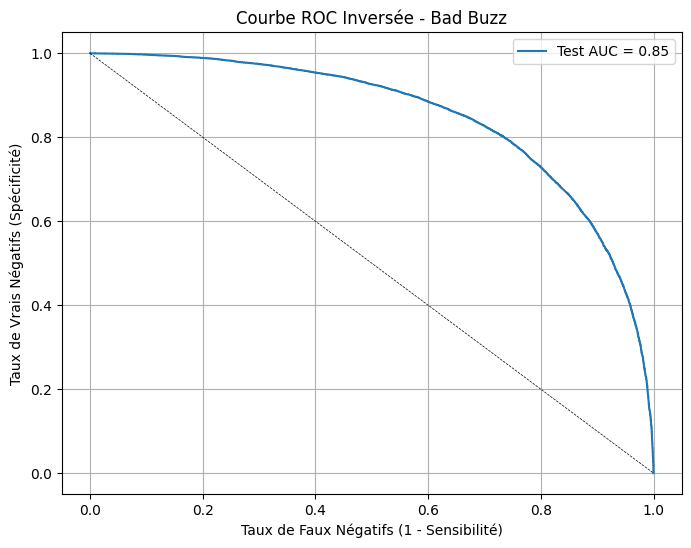

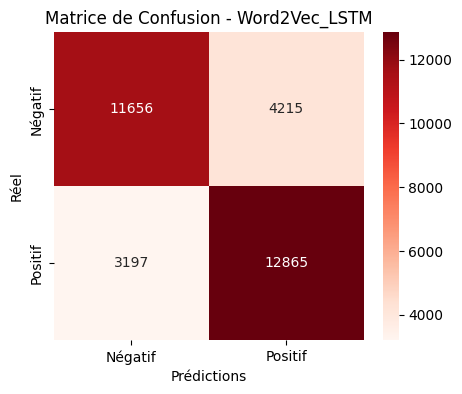


=== 📊 Tableau des performances ===
  Performance      Test
0    Accuracy  0.767889
1   Precision  0.753220
2      Recall  0.800959
3    F1 Score  0.776356
1/1 [==============================] - 0s 21ms/step


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpzl475f80\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpzl475f80\model\data\model\assets


1/1 [==============================] - 1s 518ms/step


In [55]:
# --- Construction et entraînement du modèle LSTM avec MLflow ---

# Définition du dossier des modèles (remonte d'un niveau vers "models/")
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Chemin pour sauvegarder le meilleur modèle Word2Vec LSTM
best_model_path_w2v = models_path / 'best_model_w2v.keras'

# Définition des callbacks
checkpoint_cb = ModelCheckpoint(best_model_path_w2v, save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- Construction et entraînement du modèle LSTM avec MLflow ---
mlflow.set_experiment("Détection des Bad Buzz")

with mlflow.start_run(run_name="Word2Vec_LSTM"):

    model_name = "Word2Vec_LSTM"
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)

    mlflow.log_param("model_name", model_name)
    mlflow.log_param("vocab_size", vocab_size_w2v)  
    mlflow.log_param("max_sequence_length", 50)  
    
    # Séparation en train/test
    X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_padded_w2v, y, test_size=0.2, random_state=42)

    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # Définition du modèle LSTM
    model_w2v_lstm = Sequential([
        Embedding(input_dim=vocab_size_w2v, output_dim=300, weights=[embedding_matrix_w2v], input_length=50, trainable=False), 
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    
    model_w2v_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Log des paramètres du modèle LSTM
    mlflow.log_param("embedding_dim", 300)
    mlflow.log_param("lstm_units_1", 128)
    mlflow.log_param("lstm_units_2", 64)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss_function", "binary_crossentropy")
    mlflow.log_param("activation_output", "sigmoid")

    # Entraînement avec callbacks
    history = model_w2v_lstm.fit(
        X_train_w2v, y_train_w2v,
        epochs=10, batch_size=64,
        validation_data=(X_test_w2v, y_test_w2v),
        callbacks=[checkpoint_cb, early_stopping_cb]  # Ajout de la sauvegarde
    )

    # Évaluation
    test_loss, test_accuracy = model_w2v_lstm.evaluate(X_test_w2v, y_test_w2v)

    # Prédictions pour l'entraînement
    y_train_pred_proba = model_w2v_lstm.predict(X_train_w2v).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)

    # Prédictions pour le test
    y_test_pred_proba = model_w2v_lstm.predict(X_test_w2v).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Calcul des métriques générales
    # Accuracy
    test_accuracy = accuracy_score(y_test_w2v, y_test_pred)

    # Précision = % de prédictions positives correctes
    test_precision = precision_score(y_test_w2v, y_test_pred)

    # Rappel = % de cas positifs bien détectés
    test_recall = recall_score(y_test_w2v, y_test_pred)

    # F1-score = équilibre entre précision et rappel
    test_f1 = f1_score(y_test_w2v, y_test_pred)

    # Courbes ROC et AUC
    # Courbe ROC pour les tweets positifs (classe 1)
    fpr_test, tpr_test, _ = roc_curve(y_test_w2v, y_test_pred_proba)

    # Calcul de l'AUC pour la classe positive
    auc_test = auc(fpr_test, tpr_test)

    # Courbes ROC et AUC pour les tweets négatifs (classe 0 - Bad Buzz)
    y_test_pred_proba_neg = 1 - y_test_pred_proba

    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test_w2v, y_test_pred_proba_neg)

    # Calcul de l'AUC pour la classe négative (bad buzz)
    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Courbe ROC inversée (bad buzz)
    roc_path_neg = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux Négatifs (1 - Sensibilité)')
    plt.ylabel('Taux de Vrais Négatifs (Spécificité)')
    plt.title('Courbe ROC Inversée - Bad Buzz')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(roc_path_neg)
    mlflow.log_artifact(roc_path_neg)
    plt.show()

    # Matrice de confusion
    conf_matrix_w2v = confusion_matrix(y_test_w2v, y_test_pred)
    conf_matrix_path_w2v = os.path.join(artifact_dir, "conf_matrix_w2v.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_w2v, annot=True, fmt='d', cmap='Reds', xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_w2v)
    mlflow.log_artifact(conf_matrix_path_w2v)
    plt.show()

    # Tableau des performances
    performance_table_w2v = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== 📊 Tableau des performances ===")
    print(performance_table_w2v)

    # Enregistrement du modèle TensorFlow avec MLflow
    input_example = np.expand_dims(X_train_w2v[0], axis=0)  
    signature = infer_signature(input_example, model_w2v_lstm.predict(input_example))
    
    mlflow.keras.log_model(model_w2v_lstm, "model_Word2Vec", signature=signature, input_example=input_example)


#### **GloVe + LSTM**

**<u>Commentaire :</u>**

Le nettoyage sera le même que le modèle TF-IDF avec StopWords retirés et Lemmatisation. Pas besoin de refaire une fonction.

In [56]:
# Fonction clean_text_advanced(text)

**<u>Commentaire :</u>**

Création des embeddings GloVe.

In [57]:
import numpy as np

# --- Chargement des embeddings GloVe ---

# Définition du chemin vers le fichier GloVe
glove_embeddings_path = "../data/glove.6B.300d.txt"  # Nouveau chemin

embedding_dim = 300  # Taille des vecteurs GloVe

# Charger les embeddings dans un dictionnaire
glove_embeddings = {}
with open(glove_embeddings_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

# Afficher le nombre de mots chargés
print(f"Nombre de mots chargés depuis GloVe : {len(glove_embeddings)}")


Nombre de mots chargés depuis GloVe : 400000


**<u>Commentaire :</u>**

Préparation des données pour le modèle LSTM.

In [58]:
# --- Préparation des données pour le modèle LSTM ---

# Nettoyage et tokenisation avancés
data_reduced["text_glove"] = data_reduced["text"].apply(lambda x: word_tokenize(clean_text_advanced(x)))

# Initialisation du tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_reduced["text_glove"])  

# Conversion des tweets en séquences numériques
X_seq_glove = tokenizer.texts_to_sequences(data_reduced["text_glove"])

# Ajout de padding pour uniformiser la taille des séquences
X_padded_glove = pad_sequences(X_seq_glove, maxlen=50, padding="post", truncating="post")  
y = data_reduced["target"]  # Variable cible

print("Dimensions des séquences :", X_padded_glove.shape)

# Définition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Sauvegarde du tokenizer
tokenizer_path = models_path / "tokenizer_glove.json"
with open(tokenizer_path, "w", encoding='utf-8') as f:
    json.dump(tokenizer.to_json(), f)

print(f"Tokenizer GloVe sauvegardé sous : {tokenizer_path}")


Dimensions des séquences : (159663, 50)
Tokenizer GloVe sauvegardé sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - Réalisez une analyse de sentiments grâce au Deep Learning\Git\models\tokenizer_glove.json


**<u>Commentaire :</u>**

Vérification du dataset.

In [59]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()


,target,text,clean_text_base,text_tf_advanced,text_w2v,text_glove
60400,0,had a productive cleaning day yesterday but my...,had a productive cleaning day yesterday but my...,productive cleaning day yesterday shoulder pay...,"[productive, cleaning, day, yesterday, shoulde...","[productive, cleaning, day, yesterday, shoulde..."
397317,0,i just noticed that the world is filled with l...,i just noticed that the world is filled with l...,noticed world filled lot o amatuears moron srr...,"[noticed, world, filled, lot, o, amatuears, mo...","[noticed, world, filled, lot, o, amatuears, mo..."
465261,0,Hey it is Matt. Waiting for Jen to fall on her...,hey it is matt waiting for jen to fall on her ...,hey matt waiting jen fall butt damn texting je...,"[hey, matt, waiting, jen, fall, butt, damn, te...","[hey, matt, waiting, jen, fall, butt, damn, te..."
591559,0,@cawanpink,,,[],[]
1264074,1,Im following a few pointless twitters.. Why?? ...,im following a few pointless twitters why idk ...,im following pointless twitter idk must change...,"[im, following, pointless, twitter, idk, must,...","[im, following, pointless, twitter, idk, must,..."


**<u>Commentaire :</u>**

Création de la matrice d’embeddings GloVe.

In [60]:
# --- Création de la matrice d’embeddings GloVe ---

# Taille du vocabulaire
vocab_size_glove = len(tokenizer.word_index) + 1

# Matrice des embeddings
embedding_matrix_glove = np.zeros((vocab_size_glove, embedding_dim))

# Associer chaque mot de notre vocabulaire aux embeddings GloVe
for word, i in tokenizer.word_index.items():
    if word in glove_embeddings:
        embedding_matrix_glove[i] = glove_embeddings[word]


**<u>Commentaire :</u>**

Construction et entraînement du modèle .

Epoch 1/10
1996/1996 [==============================] - 36s 17ms/step - loss: 0.5447 - accuracy: 0.7282 - val_loss: 0.5078 - val_accuracy: 0.7518
Epoch 2/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.4933 - accuracy: 0.7645 - val_loss: 0.4939 - val_accuracy: 0.7641
Epoch 3/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.4706 - accuracy: 0.7777 - val_loss: 0.4829 - val_accuracy: 0.7650
Epoch 4/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4473 - accuracy: 0.7929 - val_loss: 0.4826 - val_accuracy: 0.7695
Epoch 5/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.4221 - accuracy: 0.8071 - val_loss: 0.4837 - val_accuracy: 0.7678
Epoch 6/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.3954 - accuracy: 0.8229 - val_loss: 0.5165 - val_accuracy: 0.7621
Epoch 7/10
998/998 [==============================] - 6s 6ms/step


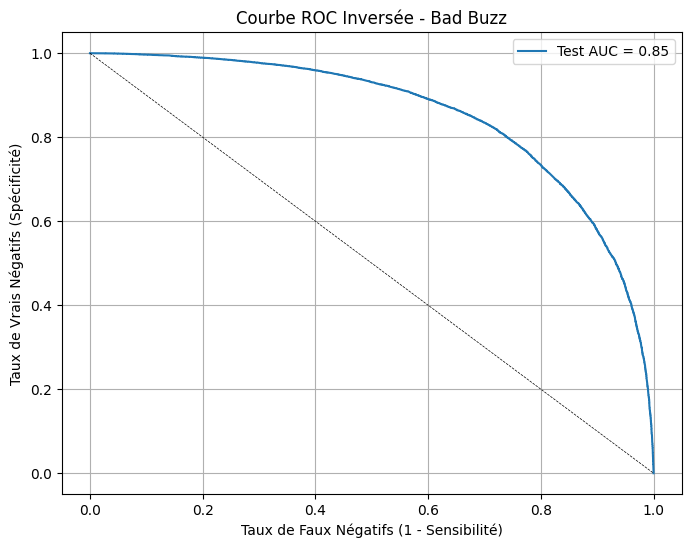

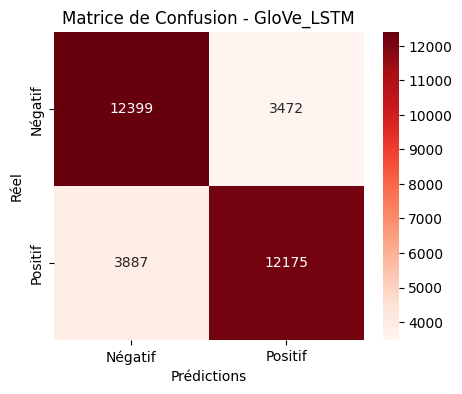


=== 📊 Tableau des performances ===
  Performance      Test
0    Accuracy  0.769549
1   Precision  0.778104
2      Recall  0.758000
3    F1 Score  0.767921
1/1 [==============================] - 0s 20ms/step


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmplazxeipb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmplazxeipb\model\data\model\assets


1/1 [==============================] - 0s 499ms/step
Modèle GloVe LSTM sauvegardé sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - Réalisez une analyse de sentiments grâce au Deep Learning\Git\models\best_model_glove.keras


In [61]:
# --- Construction et entraînement du modèle ---

# Définition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Chemin pour sauvegarder le meilleur modèle GloVe LSTM
best_model_path_glove = models_path / 'best_model_glove.keras'

# Définition des callbacks pour sauvegarde et early stopping
checkpoint_cb = ModelCheckpoint(best_model_path_glove, save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

mlflow.set_experiment("Détection des Bad Buzz")

with mlflow.start_run(run_name="GloVe_LSTM"):

    model_name = "GloVe_LSTM"
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)

    # Log du nom du modèle
    mlflow.log_param("model_name", model_name)

    # Log des paramètres du tokenizer et de la tokenisation
    mlflow.log_param("vocab_size", vocab_size_glove)
    mlflow.log_param("max_sequence_length", 50)
    
    # Séparation en train/test
    X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_padded_glove, y, test_size=0.2, random_state=42)

    # Log des paramètres de la séparation train/test
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    # Définition du modèle LSTM
    model_glove_lstm = Sequential([
        Embedding(input_dim=vocab_size_glove, output_dim=embedding_dim, weights=[embedding_matrix_glove], input_length=50, trainable=False), 
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    
    model_glove_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Log des paramètres du modèle LSTM
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("lstm_units_1", 128)
    mlflow.log_param("lstm_units_2", 64)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss_function", "binary_crossentropy")
    mlflow.log_param("activation_output", "sigmoid")

    # Entraînement
    history = model_glove_lstm.fit(
        X_train_glove, y_train_glove,
        epochs=10, batch_size=64,
        validation_data=(X_test_glove, y_test_glove),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # Log des paramètres d'entraînement
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("early_stopping", "yes")
    mlflow.log_param("early_stopping_patience", 2)

    # Évaluation
    test_loss, test_accuracy = model_glove_lstm.evaluate(X_test_glove, y_test_glove)

    # Prédictions pour l'entraînement
    y_train_pred_proba = model_glove_lstm.predict(X_train_glove).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)

    # Prédictions pour le test
    y_test_pred_proba = model_glove_lstm.predict(X_test_glove).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Calcul des métriques générales
    test_accuracy = accuracy_score(y_test_glove, y_test_pred)

    test_precision = precision_score(y_test_glove, y_test_pred)

    test_recall = recall_score(y_test_glove, y_test_pred)

    test_f1 = f1_score(y_test_glove, y_test_pred)

    # Courbes ROC et AUC
    fpr_test, tpr_test, _ = roc_curve(y_test_glove, y_test_pred_proba)

    auc_test = auc(fpr_test, tpr_test)

    # Courbes ROC et AUC pour les tweets négatifs (bad buzz)
    y_test_pred_proba_neg = 1 - y_test_pred_proba

    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test_glove, y_test_pred_proba_neg)

    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Courbe ROC inversée (bad buzz)
    roc_path_neg = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux Négatifs (1 - Sensibilité)')
    plt.ylabel('Taux de Vrais Négatifs (Spécificité)')
    plt.title('Courbe ROC Inversée - Bad Buzz')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(roc_path_neg)
    mlflow.log_artifact(roc_path_neg)
    plt.show()

    # Matrice de confusion
    conf_matrix_glove = confusion_matrix(y_test_glove, y_test_pred)
    conf_matrix_path_glove = os.path.join(artifact_dir, "conf_matrix_glove.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_glove, annot=True, fmt='d', cmap='Reds', xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_glove)
    mlflow.log_artifact(conf_matrix_path_glove)
    plt.show()

    # Tableau des performances
    performance_table_glove = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== 📊 Tableau des performances ===")
    print(performance_table_glove)

    # Sauvegarde du modèle avec MLflow
    input_example = np.expand_dims(X_train_glove[0], axis=0)  
    signature = infer_signature(input_example, model_glove_lstm.predict(input_example))
    
    mlflow.keras.log_model(model_glove_lstm, "model_GloVe", signature=signature, input_example=input_example)

print(f"Modèle GloVe LSTM sauvegardé sous : {best_model_path_glove}")

#### **FastText + LSTM**

**<u>Commentaire :</u>**

Le nettoyage sera le même que le modèle TF-IDF avec StopWords retirés et Lemmatisation. Pas besoin de refaire une fonction.

In [62]:
# Fonction clean_text_advanced(text)

**<u>Commentaire :</u>**

Création des embeddings FastText.

In [63]:
# --- Création des embeddings FastText ---

# Appliquer le nettoyage avancé et tokeniser chaque tweet
data_reduced['text_fasttext'] = data_reduced['text'].apply(lambda x: word_tokenize(clean_text_advanced(x)))

# Entraîner le modèle FastText
fasttext_model = FastText(
    sentences=data_reduced['text_fasttext'],
    vector_size=300,  # Taille des embeddings
    window=5,
    min_count=5,
    workers=4
)

# Affichage des dimensions du vocabulaire appris
print("Nombre de mots appris par FastText :", len(fasttext_model.wv))


Nombre de mots appris par FastText : 12336


**<u>Commentaire :</u>**

Check du dataset.

In [64]:
# --- Check de notre dataset ---

# Afficher 5 lignes du dataset
data_reduced.head()


,target,text,clean_text_base,text_tf_advanced,text_w2v,text_glove,text_fasttext
60400,0,had a productive cleaning day yesterday but my...,had a productive cleaning day yesterday but my...,productive cleaning day yesterday shoulder pay...,"[productive, cleaning, day, yesterday, shoulde...","[productive, cleaning, day, yesterday, shoulde...","[productive, cleaning, day, yesterday, shoulde..."
397317,0,i just noticed that the world is filled with l...,i just noticed that the world is filled with l...,noticed world filled lot o amatuears moron srr...,"[noticed, world, filled, lot, o, amatuears, mo...","[noticed, world, filled, lot, o, amatuears, mo...","[noticed, world, filled, lot, o, amatuears, mo..."
465261,0,Hey it is Matt. Waiting for Jen to fall on her...,hey it is matt waiting for jen to fall on her ...,hey matt waiting jen fall butt damn texting je...,"[hey, matt, waiting, jen, fall, butt, damn, te...","[hey, matt, waiting, jen, fall, butt, damn, te...","[hey, matt, waiting, jen, fall, butt, damn, te..."
591559,0,@cawanpink,,,[],[],[]
1264074,1,Im following a few pointless twitters.. Why?? ...,im following a few pointless twitters why idk ...,im following pointless twitter idk must change...,"[im, following, pointless, twitter, idk, must,...","[im, following, pointless, twitter, idk, must,...","[im, following, pointless, twitter, idk, must,..."


**<u>Commentaire :</u>**

Préparation des données pour le modèle LSTM.

In [65]:
# --- Préparation des données pour le modèle LSTM ---

# Initialisation du tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_reduced["text_fasttext"])  # Basé sur les tokens extraits pour FastText

# Conversion des tweets en séquences numériques
X_seq_fasttext = tokenizer.texts_to_sequences(data_reduced["text_fasttext"])

# Ajout de padding pour uniformiser la taille des séquences
X_padded_fasttext = pad_sequences(X_seq_fasttext, maxlen=50, padding="post", truncating="post")  # 50 mots max par tweet
y = data_reduced["target"]  # Variable cible

print("Dimensions des séquences :", X_padded_fasttext.shape)

# Définition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Sauvegarde du tokenizer
tokenizer_path = models_path / "tokenizer_fasttext.json"
with open(tokenizer_path, "w", encoding='utf-8') as f:
    json.dump(tokenizer.to_json(), f)

print(f"Tokenizer FastText sauvegardé sous : {tokenizer_path}")


Dimensions des séquences : (159663, 50)
Tokenizer FastText sauvegardé sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - Réalisez une analyse de sentiments grâce au Deep Learning\Git\models\tokenizer_fasttext.json


**<u>Commentaire :</u>**

Création de la matrice d’embeddings.

In [66]:
# --- Création de la matrice d’embeddings ---

# Taille du vocabulaire
vocab_size_fasttext = len(tokenizer.word_index) + 1

# Matrice des embeddings
embedding_matrix_fasttext = np.zeros((vocab_size_fasttext, 300))

# Associer chaque mot de notre vocabulaire aux embeddings FastText
for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix_fasttext[i] = fasttext_model.wv[word]


**<u>Commentaire :</u>**

Construction et entraînement du modèle.

Epoch 1/10
1996/1996 [==============================] - 35s 17ms/step - loss: 0.5353 - accuracy: 0.7321 - val_loss: 0.5168 - val_accuracy: 0.7414
Epoch 2/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.5077 - accuracy: 0.7511 - val_loss: 0.4943 - val_accuracy: 0.7600
Epoch 3/10
1996/1996 [==============================] - 35s 17ms/step - loss: 0.4952 - accuracy: 0.7584 - val_loss: 0.4898 - val_accuracy: 0.7610
Epoch 4/10
1996/1996 [==============================] - 33s 17ms/step - loss: 0.4833 - accuracy: 0.7654 - val_loss: 0.4885 - val_accuracy: 0.7645
Epoch 5/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4734 - accuracy: 0.7710 - val_loss: 0.4856 - val_accuracy: 0.7637
Epoch 6/10
1996/1996 [==============================] - 33s 16ms/step - loss: 0.4630 - accuracy: 0.7774 - val_loss: 0.4905 - val_accuracy: 0.7594
Epoch 7/10
1996/1996 [==============================] - 35s 17ms/step - loss: 0.4529 - accuracy: 0.7841 - val_loss: 0.4865 -

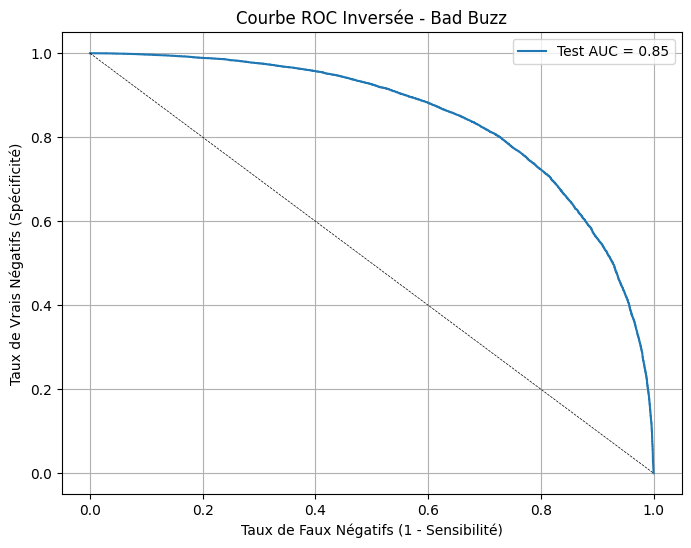

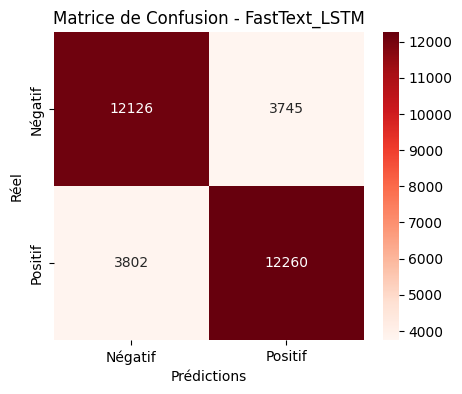


=== 📊 Tableau des performances ===
  Performance      Test
0    Accuracy  0.763661
1   Precision  0.766011
2      Recall  0.763292
3    F1 Score  0.764649
1/1 [==============================] - 0s 19ms/step


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpwbh941sa\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpwbh941sa\model\data\model\assets


1/1 [==============================] - 0s 493ms/step
Modèle FastText LSTM sauvegardé sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - Réalisez une analyse de sentiments grâce au Deep Learning\Git\models\best_model_fasttext.keras


In [67]:
# --- Construction et entraînement du modèle FastText ---

# Définition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Chemin pour sauvegarder le meilleur modèle FastText LSTM
best_model_path_fasttext = models_path / 'best_model_fasttext.keras'

# Définition des callbacks pour sauvegarde et early stopping
checkpoint_cb = ModelCheckpoint(best_model_path_fasttext, save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

mlflow.set_experiment("Détection des Bad Buzz")

with mlflow.start_run(run_name="FastText_LSTM"):

    model_name = "FastText_LSTM"
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)

    # Log du nom du modèle
    mlflow.log_param("model_name", model_name)

    # Log des paramètres du modèle FastText
    mlflow.log_param("fasttext_vector_size", 300)
    mlflow.log_param("fasttext_window", 5)
    mlflow.log_param("fasttext_min_count", 5)
    mlflow.log_param("fasttext_workers", 4)
        
    # Log des paramètres du tokenizer et de la tokenisation
    mlflow.log_param("vocab_size", vocab_size_fasttext)
    mlflow.log_param("max_sequence_length", 50)
        
    # Séparation en train/test
    X_train_fasttext, X_test_fasttext, y_train_fasttext, y_test_fasttext = train_test_split(X_padded_fasttext, y, test_size=0.2, random_state=42)
    
    # Log des paramètres de la séparation train/test
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    # Définition du modèle LSTM
    model_fasttext_lstm = Sequential([
        Embedding(input_dim=vocab_size_fasttext, output_dim=embedding_dim, weights=[embedding_matrix_fasttext], input_length=50, trainable=False), 
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    
    model_fasttext_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Log des paramètres du modèle LSTM
    mlflow.log_param("embedding_dim", 300)
    mlflow.log_param("lstm_units_1", 128)
    mlflow.log_param("lstm_units_2", 64)
    mlflow.log_param("dropout_rate", 0.5)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss_function", "binary_crossentropy")
    mlflow.log_param("activation_output", "sigmoid")
    
    # Entraînement
    history = model_fasttext_lstm.fit(
        X_train_fasttext, y_train_fasttext,
        epochs=10, batch_size=64,
        validation_data=(X_test_fasttext, y_test_fasttext),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # Log des paramètres d'entraînement
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("early_stopping", "yes")
    mlflow.log_param("early_stopping_patience", 2)
    
    # Évaluation
    test_loss, test_accuracy = model_fasttext_lstm.evaluate(X_test_fasttext, y_test_fasttext)

    # Prédictions pour l'entraînement
    y_train_pred_proba = model_fasttext_lstm.predict(X_train_fasttext).flatten()
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)

    # Prédictions pour le test
    y_test_pred_proba = model_fasttext_lstm.predict(X_test_fasttext).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Calcul des métriques générales
    test_accuracy = accuracy_score(y_test_fasttext, y_test_pred)

    test_precision = precision_score(y_test_fasttext, y_test_pred)

    test_recall = recall_score(y_test_fasttext, y_test_pred)

    test_f1 = f1_score(y_test_fasttext, y_test_pred)

    # Courbes ROC et AUC
    fpr_test, tpr_test, _ = roc_curve(y_test_fasttext, y_test_pred_proba)

    auc_test = auc(fpr_test, tpr_test)

    # Courbes ROC et AUC pour les tweets négatifs (bad buzz)
    y_test_pred_proba_neg = 1 - y_test_pred_proba

    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test_fasttext, y_test_pred_proba_neg)

    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)


    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Courbe ROC inversée (bad buzz)
    roc_path_neg = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux Négatifs (1 - Sensibilité)')
    plt.ylabel('Taux de Vrais Négatifs (Spécificité)')
    plt.title('Courbe ROC Inversée - Bad Buzz')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(roc_path_neg)
    mlflow.log_artifact(roc_path_neg)
    plt.show()

    # Matrice de confusion
    conf_matrix_fasttext = confusion_matrix(y_test_fasttext, y_test_pred)
    conf_matrix_path_fasttext = os.path.join(artifact_dir, "conf_matrix_fasttext.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_fasttext, annot=True, fmt='d', cmap='Reds', xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_fasttext)
    mlflow.log_artifact(conf_matrix_path_fasttext)
    plt.show()

    # Tableau des performances
    performance_table_fasttext = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== 📊 Tableau des performances ===")
    print(performance_table_fasttext)

    # Sauvegarde du modèle avec MLflow
    input_example = np.expand_dims(X_train_fasttext[0], axis=0)  
    signature = infer_signature(input_example, model_fasttext_lstm.predict(input_example))
    
    mlflow.keras.log_model(model_fasttext_lstm, "model_FastText", signature=signature, input_example=input_example)

print(f"Modèle FastText LSTM sauvegardé sous : {best_model_path_fasttext}")


#### **BERT**

**<u>Commentaire :</u>**

Chargement du modèle BERT et Tokenizer.

In [68]:
# --- Chargement du modèle BERT Distillé et Tokenizer ---

# Charger le tokenizer DistilBERT pré-entraîné
bert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Charger le modèle DistilBERT pré-entraîné
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

print("Modèle DistilBERT chargé avec succès.")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Modèle DistilBERT chargé avec succès.


**<u>Commentaire :</u>**

Prétraitement des textes pour BERT.

In [69]:
# --- Prétraitement des données pour BERT ---

# Encode les textes avec le tokenizer BERT en entrée pour le modèle
def encode_texts_bert(texts, max_length=64):
    return bert_tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

# Encodage des tweets
encoded_texts = encode_texts_bert(data_reduced['text'])

# Extraction des entrées nécessaires à BERT
X_bert = encoded_texts['input_ids']
y = data_reduced['target']

# Afficher les dimensions
print("Encodage terminé. Dimensions des séquences :", X_bert.shape)

# Définition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Sauvegarde du tokenizer BERT
bert_tokenizer_path = models_path / "bert_tokenizer"
bert_tokenizer.save_pretrained(bert_tokenizer_path)

print(f"Tokenizer BERT sauvegardé sous : {bert_tokenizer_path}")


Encodage terminé. Dimensions des séquences : (159663, 64)
Tokenizer BERT sauvegardé sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - Réalisez une analyse de sentiments grâce au Deep Learning\Git\models\bert_tokenizer


**<u>Commentaire :</u>**

Séparation des données train / test.

In [70]:
# --- Séparation des données en train/test ---

# Conversion des labels en tenseurs float32
y = tf.convert_to_tensor(y, dtype=tf.float32)

# --- Séparation train/test ---
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert.numpy(), y.numpy(), test_size=0.2, random_state=42
)

print("Séparation train/test effectuée.")


Séparation train/test effectuée.


**<u>Commentaire :</u>**

Construction et entraînement du modèle BERT.

Modèle BERT et tenseurs placés sur : /gpu:0
Epoch 1/5
7984/7984 [==============================] - 355s 44ms/step - loss: 0.4174 - accuracy: 0.8188 - val_loss: 0.3801 - val_accuracy: 0.8399
Epoch 2/5
7984/7984 [==============================] - 340s 43ms/step - loss: 0.3192 - accuracy: 0.8682 - val_loss: 0.3789 - val_accuracy: 0.8414
Epoch 3/5
7984/7984 [==============================] - 337s 42ms/step - loss: 0.2234 - accuracy: 0.9123 - val_loss: 0.4291 - val_accuracy: 0.8384
Epoch 4/5
7984/7984 [==============================] - 336s 42ms/step - loss: 0.1408 - accuracy: 0.9471 - val_loss: 0.4841 - val_accuracy: 0.8371
Epoch 5/5
998/998 [==============================] - 19s 18ms/step


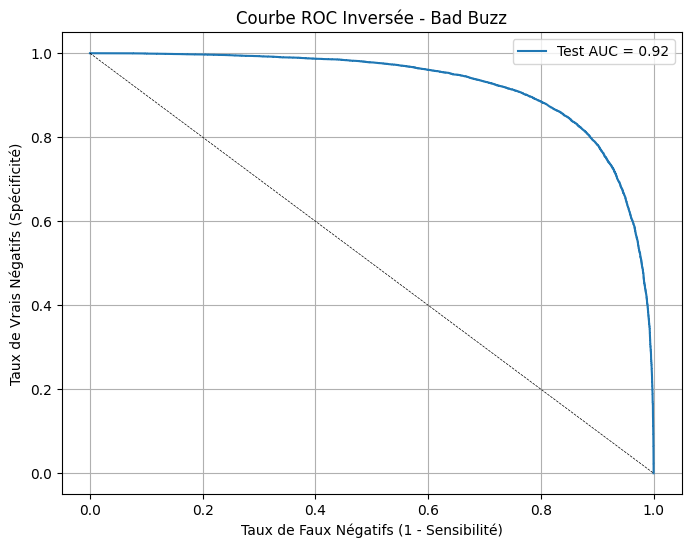

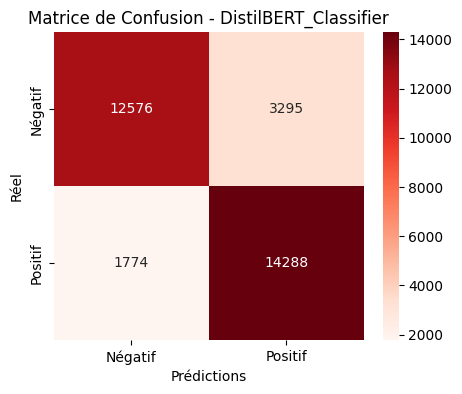


=== 📊 Tableau des performances ===
  Performance      Test
0    Accuracy  0.841261
1   Precision  0.812603
2      Recall  0.889553
3    F1 Score  0.849339
1/1 [==============================] - 0s 31ms/step


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpt9o2vf7q\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpt9o2vf7q\model\data\model\assets
2025/02/17 11:00:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\MOUSSE~1\AppData\Local\Temp\tmpt9o2vf7q\model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.0']. Set logging level to DEBUG to see the full traceback. 


2025/02/17 11:00:22 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      101,
      2987,
      1005,
      1056,
      2514,
      2205,
      2092,
      102,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0,
      0
    ]
  ]
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving inp

Sauvegardes effectuées avec succès :
Modèle de classification DistilBERT sauvegardé sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - Réalisez une analyse de sentiments grâce au Deep Learning\Git\models\best_model_bert.keras
Modèle pré-entraîné DistilBERT sauvegardé sous : C:\Users\Moussetik\Downloads\Formation - AI Engineer\Projet 07 - Réalisez une analyse de sentiments grâce au Deep Learning\Git\models\distilbert_model


In [71]:
# --- Construction et entraînement du modèle BERT ---

# Définition du dossier "models"
models_path = Path("../models").resolve()
models_path.mkdir(parents=True, exist_ok=True)

# Chemin pour sauvegarder le meilleur modèle BERT
best_model_path_bert = models_path / 'best_model_bert.keras'

# Définition des callbacks pour sauvegarde et early stopping
checkpoint_cb = ModelCheckpoint(best_model_path_bert, save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Débloquer l'entraînement des couches BERT
#for layer in bert_model.layers:
#    layer.trainable = True

# Désactiver le pooler qui est inutile
#for layer in bert_model.layers:
#    if "pooler" in layer.name:
#        layer.trainable = False
        
mlflow.set_experiment("Détection des Bad Buzz")

with mlflow.start_run(run_name="DistilBERT_Classifier"):

    model_name = "DistilBERT_Classifier"
    artifact_dir = f"artifacts/{model_name}/"
    os.makedirs(artifact_dir, exist_ok=True)

    # Log du modèle
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("max_sequence_length", 64)
    
    # Architecture BERT corrigée
    input_layer = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name="input_ids")
    
    # Récupération des embeddings BERT sans pooler
    bert_output = bert_model(input_layer)[0]  
    cls_token = tf.keras.layers.Dense(bert_output.shape[-1], activation=None)(bert_output[:, 0, :])
    
    dropout_layer = tf.keras.layers.Dropout(0.4)(cls_token)
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_layer)

    model_bert = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Optimiseur AdamW + Scheduler
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

    model_bert.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # Vérification GPU
    device = "/gpu:0" if tf.config.list_physical_devices('GPU') else "/cpu:0"
    with tf.device(device):
        X_train_bert = tf.convert_to_tensor(X_train_bert, dtype=tf.int32)
        X_test_bert = tf.convert_to_tensor(X_test_bert, dtype=tf.int32)
        y_train_bert = tf.convert_to_tensor(y_train_bert, dtype=tf.float32)
        y_test_bert = tf.convert_to_tensor(y_test_bert, dtype=tf.float32)

    print(f"Modèle BERT et tenseurs placés sur : {device}")

    # Callbacks pour optimiser l'entraînement
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1) # patience=1 comme ça la LR diminue dès que val_loss stagne
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    # Entraînement
    history = model_bert.fit(
        X_train_bert, y_train_bert,
        epochs=5, batch_size=16,
        validation_data=(X_test_bert, y_test_bert),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # Évaluation
    test_loss, test_accuracy = model_bert.evaluate(X_test_bert, y_test_bert)

    # Prédictions pour le test
    y_test_pred_proba = model_bert.predict(X_test_bert).flatten()
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Calcul des métriques générales
    test_precision = precision_score(y_test_bert, y_test_pred)
    test_recall = recall_score(y_test_bert, y_test_pred)
    test_f1 = f1_score(y_test_bert, y_test_pred)

    # Courbes ROC et AUC
    fpr_test, tpr_test, _ = roc_curve(y_test_bert, y_test_pred_proba)
    auc_test = auc(fpr_test, tpr_test)

    # Courbes ROC et AUC pour les tweets négatifs (bad buzz)
    y_test_pred_proba_neg = 1 - y_test_pred_proba
    fpr_test_neg, tpr_test_neg, _ = roc_curve(y_test_bert, y_test_pred_proba_neg)
    auc_test_neg = auc(fpr_test_neg, tpr_test_neg)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("Test Accuracy", test_accuracy)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)
    mlflow.log_metric("Test F1 Score", test_f1)
    mlflow.log_metric("Test AUC", auc_test)
    mlflow.log_metric("Test AUC Bad Buzz", auc_test_neg)

    # Courbe ROC inversée (bad buzz)
    roc_path_neg = os.path.join(artifact_dir, "roc_curve_bad_buzz.png")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test_neg, 1 - tpr_test_neg, label=f'Test AUC = {1 - auc_test_neg:.2f}', linestyle='-')
    plt.plot([0, 1], [1, 0], 'k--', lw=0.5)
    plt.xlabel('Taux de Faux Négatifs (1 - Sensibilité)')
    plt.ylabel('Taux de Vrais Négatifs (Spécificité)')
    plt.title('Courbe ROC Inversée - Bad Buzz')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(roc_path_neg)
    mlflow.log_artifact(roc_path_neg)
    plt.show()

    # Matrice de confusion
    conf_matrix_bert = confusion_matrix(y_test_bert, y_test_pred)
    conf_matrix_path_bert = os.path.join(artifact_dir, "conf_matrix_bert.png")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_bert, annot=True, fmt='d', cmap='Reds', xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.savefig(conf_matrix_path_bert)
    mlflow.log_artifact(conf_matrix_path_bert)
    plt.show()

    # Tableau des performances
    performance_table_bert = pd.DataFrame({
        'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Test': [test_accuracy, test_precision, test_recall, test_f1]
    })

    print("\n=== 📊 Tableau des performances ===")
    print(performance_table_bert)

    # Sauvegarde du modèle avec MLflow
    input_example = np.expand_dims(X_test_bert[0], axis=0)  
    signature = infer_signature(input_example, model_bert.predict(input_example))
    
    mlflow.keras.log_model(model_bert, "model_BERT", signature=signature, input_example=input_example)

    # Sauvegarde du modèle DistilBERT
    bert_model_path = models_path / "distilbert_model"
    bert_model.save_pretrained(bert_model_path)
    
# Affichage 
print(f"Sauvegardes effectuées avec succès :\n"
      f"Modèle de classification DistilBERT sauvegardé sous : {best_model_path_bert}\n"
      f"Modèle pré-entraîné DistilBERT sauvegardé sous : {bert_model_path}")